In [410]:
from __future__ import division, print_function
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
def random_split(spectra, test_size=0.3, random_state=None, shuffle=True, stratify=None):
    """implement random_split by using sklearn.model_selection.train_test_split function. See
    http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    for more infomation.
    """
    return train_test_split(
        spectra,
        test_size=test_size,
        random_state=random_state,
        shuffle=shuffle,
        stratify=stratify)


def kennardstone(spectra, test_size=0.2, metric='euclidean', *args, **kwargs):
    """Kennard Stone Sample Split method
    Parameters
    ----------
    spectra: ndarray, shape of i x j
        i spectrums and j variables (wavelength/wavenumber/ramam shift and so on)
    test_size : float, int
        if float, then round(i x (1-test_size)) spectrums are selected as test data, by default 0.25
        if int, then test_size is directly used as test data size
    metric : str, optional
        The distance metric to use, by default 'euclidean'
        See scipy.spatial.distance.cdist for more infomation
    Returns
    -------
    select_pts: list
        index of selected spetrums as train data, index is zero based
    remaining_pts: list
        index of remaining spectrums as test data, index is zero based
    References
    --------
    Kennard, R. W., & Stone, L. A. (1969). Computer aided design of experiments.
    Technometrics, 11(1), 137-148. (https://www.jstor.org/stable/1266770)
    """

    if test_size < 1:
        train_size = round(spectra.shape[0] * (1 - test_size))
    else:
        train_size = spectra.shape[0] - round(test_size)

    if train_size > 2:
        distance = cdist(spectra, spectra, metric=metric, *args, **kwargs)
        select_pts, remaining_pts = max_min_distance_split(distance, train_size)
    else:
        raise ValueError("train sample size should be at least 2")

    return select_pts, remaining_pts


def spxy(spectra, yvalues, test_size=0.2, metric='euclidean', *args, **kwargs):
    """SPXY Sample Split method
    Parameters
    ----------
    spectra: ndarray, shape of i x j
        i spectrums and j variables (wavelength/wavenumber/ramam shift and so on)
    test_size : float, int
        if float, then round(i x (1-test_size)) spectrums are selected as test data, by default 0.25
        if int, then test_size is directly used as test data size
    metric : str, optional
        The distance metric to use, by default 'euclidean'
        See scipy.spatial.distance.cdist for more infomation
    Returns
    -------
    select_pts: list
        index of selected spetrums as train data, index is zero based
    remaining_pts: list
        index of remaining spectrums as test data, index is zero based
    References
    ---------
    Galvao et al. (2005). A method for calibration and validation subset partitioning.
    Talanta, 67(4), 736-740. (https://www.sciencedirect.com/science/article/pii/S003991400500192X)
    """

    if test_size < 1:
        train_size = round(spectra.shape[0] * (1 - test_size))
    else:
        train_size = spectra.shape[0] - round(test_size)

    if train_size > 2:
        yvalues = yvalues.reshape(yvalues.shape[0], -1)
        distance_spectra = cdist(spectra, spectra, metric=metric, *args, **kwargs)
        distance_y = cdist(yvalues, yvalues, metric=metric, *args, **kwargs)
        distance_spectra = distance_spectra / distance_spectra.max()
        distance_y = distance_y / distance_y.max()

        distance = distance_spectra + distance_y
        select_pts, remaining_pts = max_min_distance_split(distance, train_size)
    else:
        raise ValueError("train sample size should be at least 2")

    return select_pts, remaining_pts


def max_min_distance_split(distance, train_size):
    """sample set split method based on maximun minimun distance, which is the core of Kennard Stone
    method
    Parameters
    ----------
    distance : distance matrix
        semi-positive real symmetric matrix of a certain distance metric
    train_size : train data sample size
        should be greater than 2
    Returns
    -------
    select_pts: list
        index of selected spetrums as train data, index is zero-based
    remaining_pts: list
        index of remaining spectrums as test data, index is zero-based
    """

    select_pts = []
    remaining_pts = [x for x in range(distance.shape[0])]

    # first select 2 farthest points
    first_2pts = np.unravel_index(np.argmax(distance), distance.shape)
    select_pts.append(first_2pts[0])
    select_pts.append(first_2pts[1])

    # remove the first 2 points from the remaining list
    remaining_pts.remove(first_2pts[0])
    remaining_pts.remove(first_2pts[1])

    for i in range(train_size - 2):
        # find the maximum minimum distance
        select_distance = distance[select_pts, :]
        min_distance = select_distance[:, remaining_pts]
        min_distance = np.min(min_distance, axis=0)
        max_min_distance = np.max(min_distance)

        # select the first point (in case that several distances are the same, choose the first one)
        points = np.argwhere(select_distance == max_min_distance)[:, 1].tolist()
        for point in points:
            if point in select_pts:
                pass
            else:
                select_pts.append(point)
                remaining_pts.remove(point)
                break
    return select_pts, remaining_pts

In [412]:
import sys
import os
import math
import re
import json
import scipy
import matplotlib
import matplotlib.pyplot as plt
# 指定其他字体，例如SimHei（黑体）
plt.rcParams['font.family'] = 'Arial'
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import IPython.display

from sklearn.metrics import *  # we use global() to access the imported functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier # ExtraTreeClassifier only works in ensembles
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
# from scipy.integrate import quad
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.preprocessing import OneHotEncoder
from statsmodels.multivariate import manova
from statsmodels.stats.contingency_tables import mcnemar, cochrans_q

from pyNNRW.elm import ELMClassifier
from pyNNRW.rvfl import RVFLClassifier

from qsi.vis.plt2base64 import plt2html
from qsi.vis.plot_components import plot_components_2d
from qsi.vis.feature_importance import plot_feature_importance
from qsi.vis.unsupervised_dimension_reductions import unsupervised_dimension_reductions
from cla.vis.confusion_matrix import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import top_k_accuracy_score, classification_report

X.shape (50, 1322)  y.shape (50,)


窗函数预处理（max）: binning window width =  1 / 0.2 = 5


消除基线飘移: baseline removal (regularization = 10.0, residual penalty asymetry = 0.01)


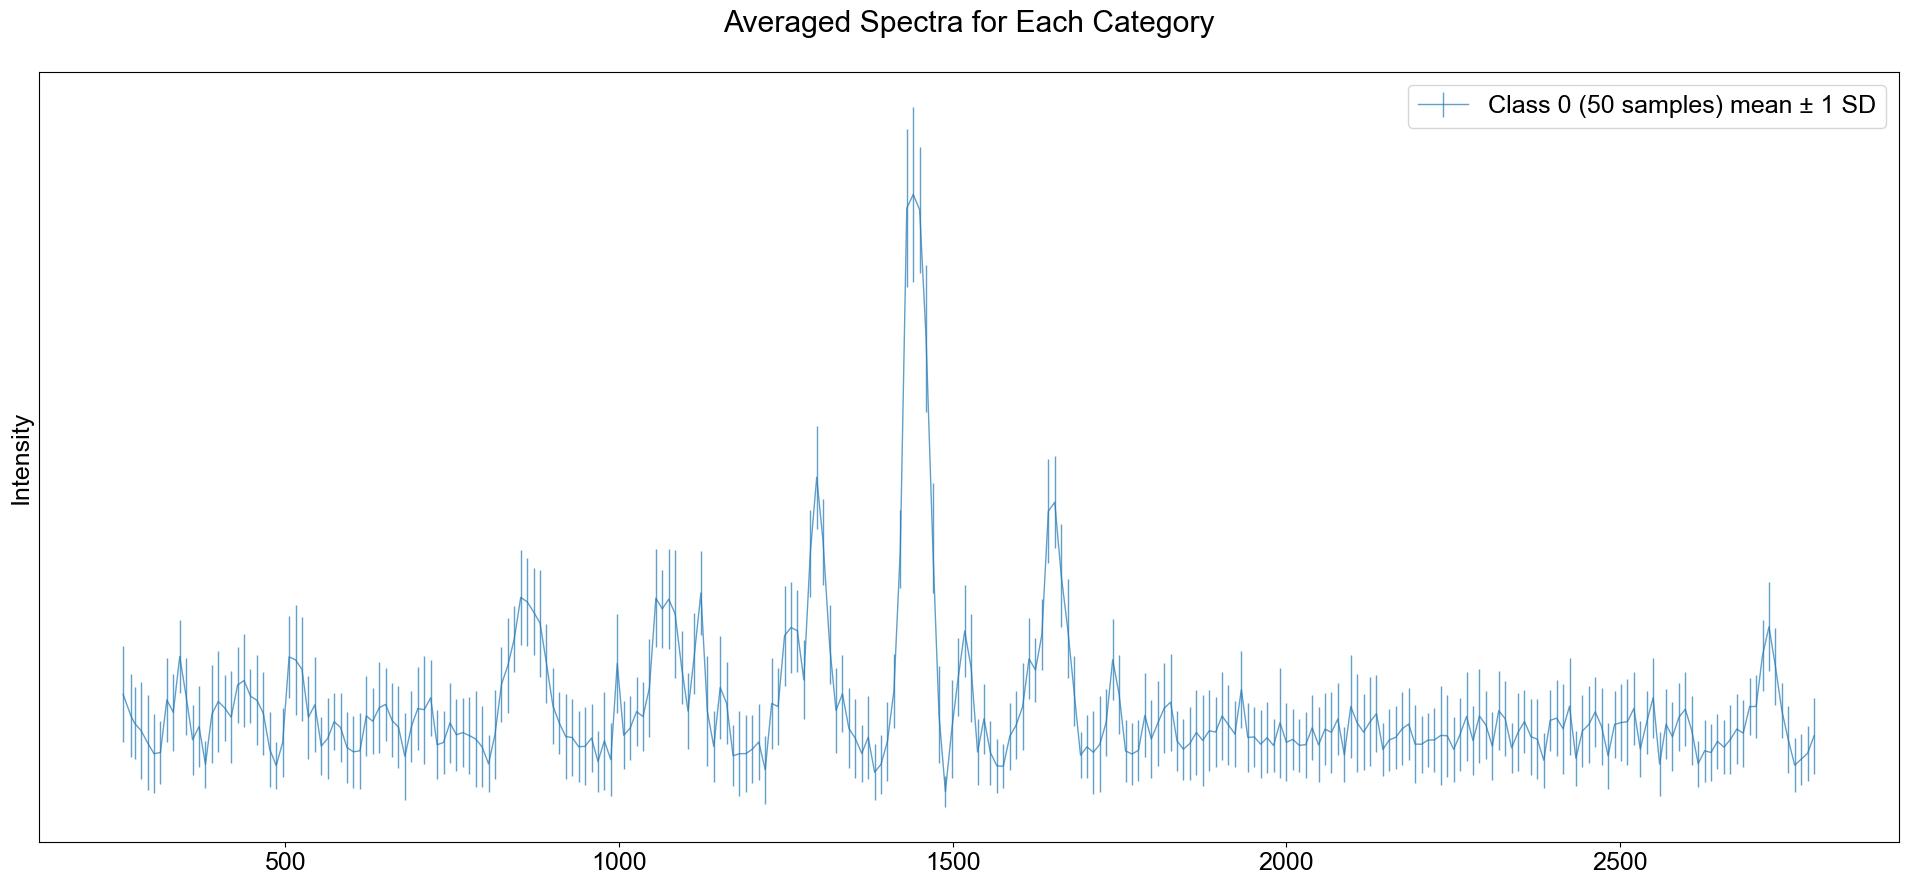

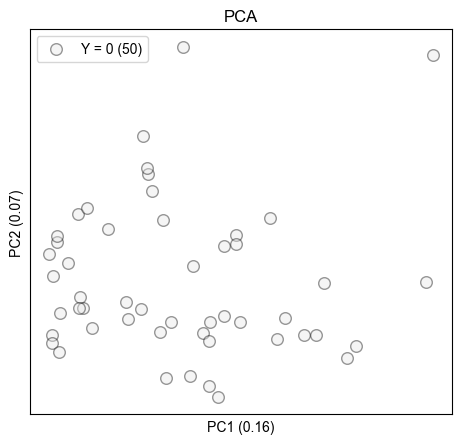

In [414]:
from qsi import io

X, y, X_names, labels = io.open_dataset('G-CQ畅轻merged_data.CSV',x_range = list(range(104,1426))) # x_range = list(range(100:))

from qsi import pipeline
X, X_names = pipeline.preprocess_dataset(X, X_names, 
                                         pres = [('max', 0.2),('baseline_removal', (1e1, 1e-2))])

io.draw_class_average(X, y, X_names, labels=labels, SD=1, shift=800)

_ = io.scatter_plot(X, y, labels=labels)

In [65]:
X.shape

(50, 264)

In [67]:
select_pts, remaining_pts = kennardstone(X, test_size=0.2, metric='euclidean')

In [69]:
X_train = X[select_pts]
y_train = y[select_pts]

X_test = X[remaining_pts]
y_test = y[remaining_pts]

In [71]:
import numpy as np

# 保存训练集数据
np.savetxt('CQ畅轻.train_data.csv', X_train, delimiter=',')
np.savetxt('CQ畅轻.train_labels.csv', y_train, delimiter=',')

# 保存测试集数据
np.savetxt('CQ畅轻.test_data.csv', X_test, delimiter=',')
np.savetxt('CQ畅轻.test_labels.csv', y_test, delimiter=',')

X.shape (50, 1322)  y.shape (50,)


窗函数预处理（max）: binning window width =  1 / 0.2 = 5


消除基线飘移: baseline removal (regularization = 10.0, residual penalty asymetry = 0.01)


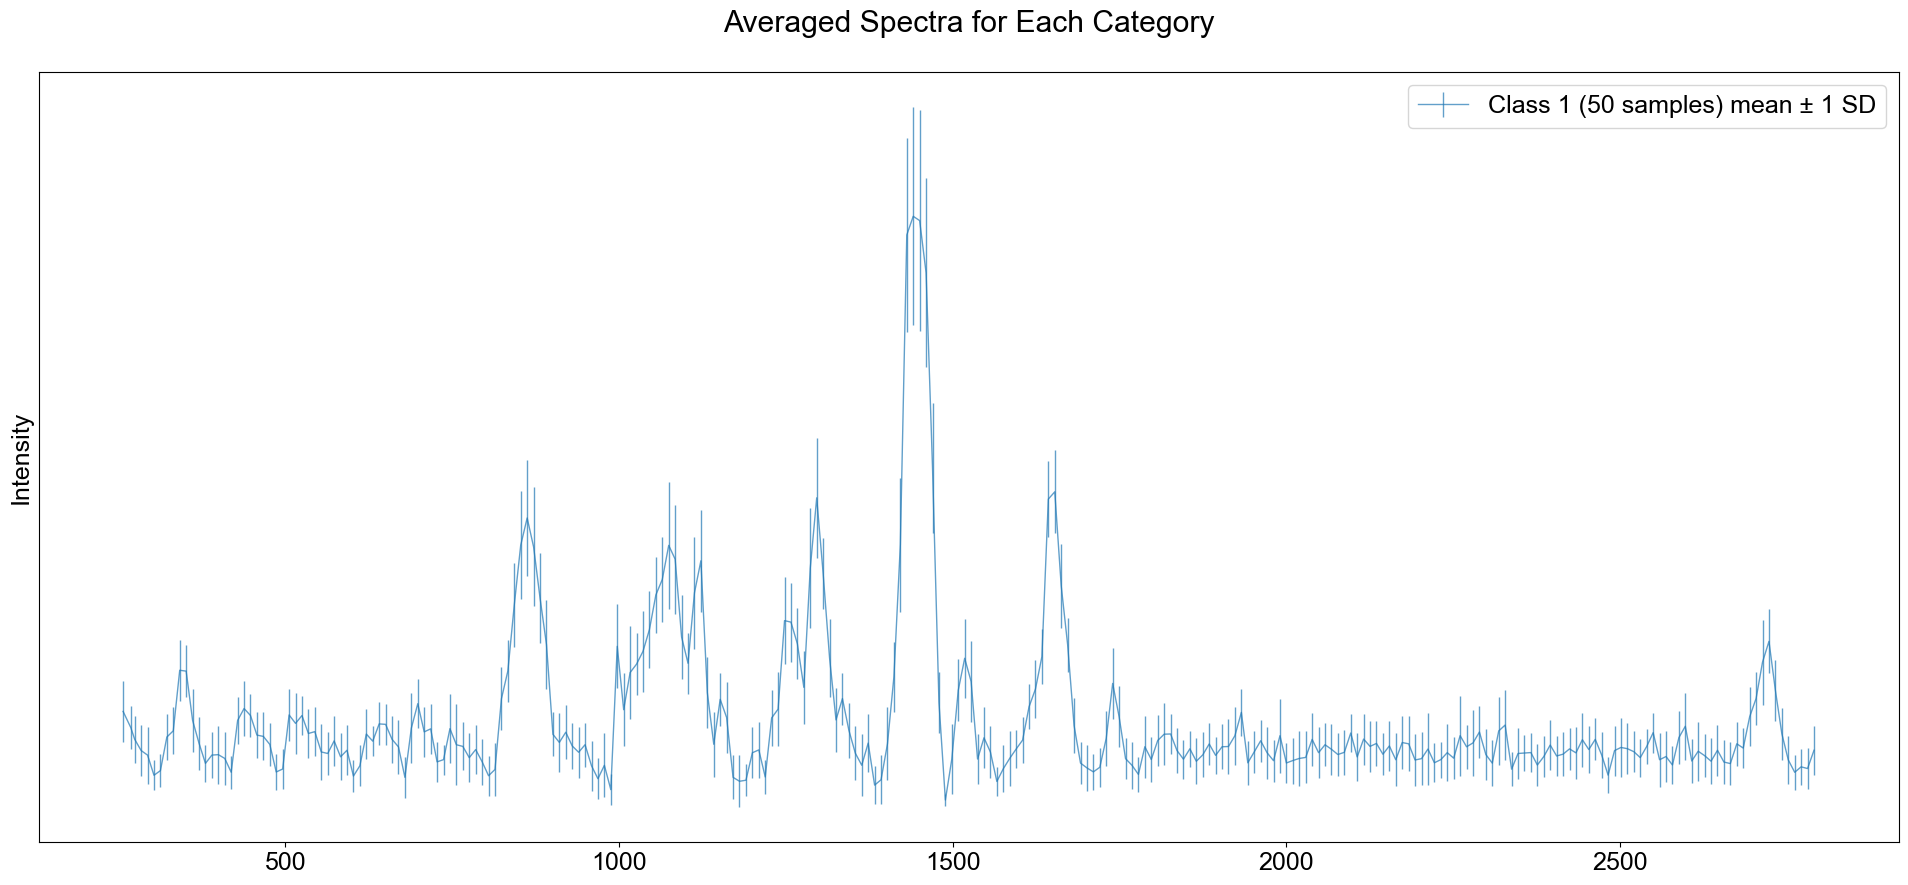

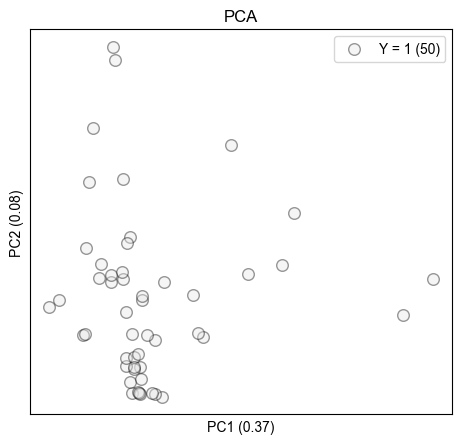

In [73]:
from qsi import io

X, y, X_names, labels = io.open_dataset('G-SNTX水牛同学merged_data.CSV',x_range = list(range(104,1426))) # x_range = list(range(100:))

from qsi import pipeline
X, X_names = pipeline.preprocess_dataset(X, X_names, 
                                         pres = [('max', 0.2),('baseline_removal', (1e1, 1e-2))])

io.draw_class_average(X, y, X_names, labels=labels, SD=1, shift=800)

_ = io.scatter_plot(X, y, labels=labels)

In [75]:
X.shape

(50, 264)

In [77]:
select_pts, remaining_pts = kennardstone(X, test_size=0.2, metric='euclidean')

In [79]:
X_train = X[select_pts]
y_train = y[select_pts]

X_test = X[remaining_pts]
y_test = y[remaining_pts]

In [81]:
import numpy as np

# 保存训练集数据
np.savetxt('SNTX水牛同学.train_data.csv', X_train, delimiter=',')
np.savetxt('SNTX水牛同学.train_labels.csv', y_train, delimiter=',')

# 保存测试集数据
np.savetxt('SNTX水牛同学.test_data.csv', X_test, delimiter=',')
np.savetxt('SNTX水牛同学.test_labels.csv', y_test, delimiter=',')

X.shape (50, 1322)  y.shape (50,)


窗函数预处理（max）: binning window width =  1 / 0.2 = 5


消除基线飘移: baseline removal (regularization = 10.0, residual penalty asymetry = 0.01)


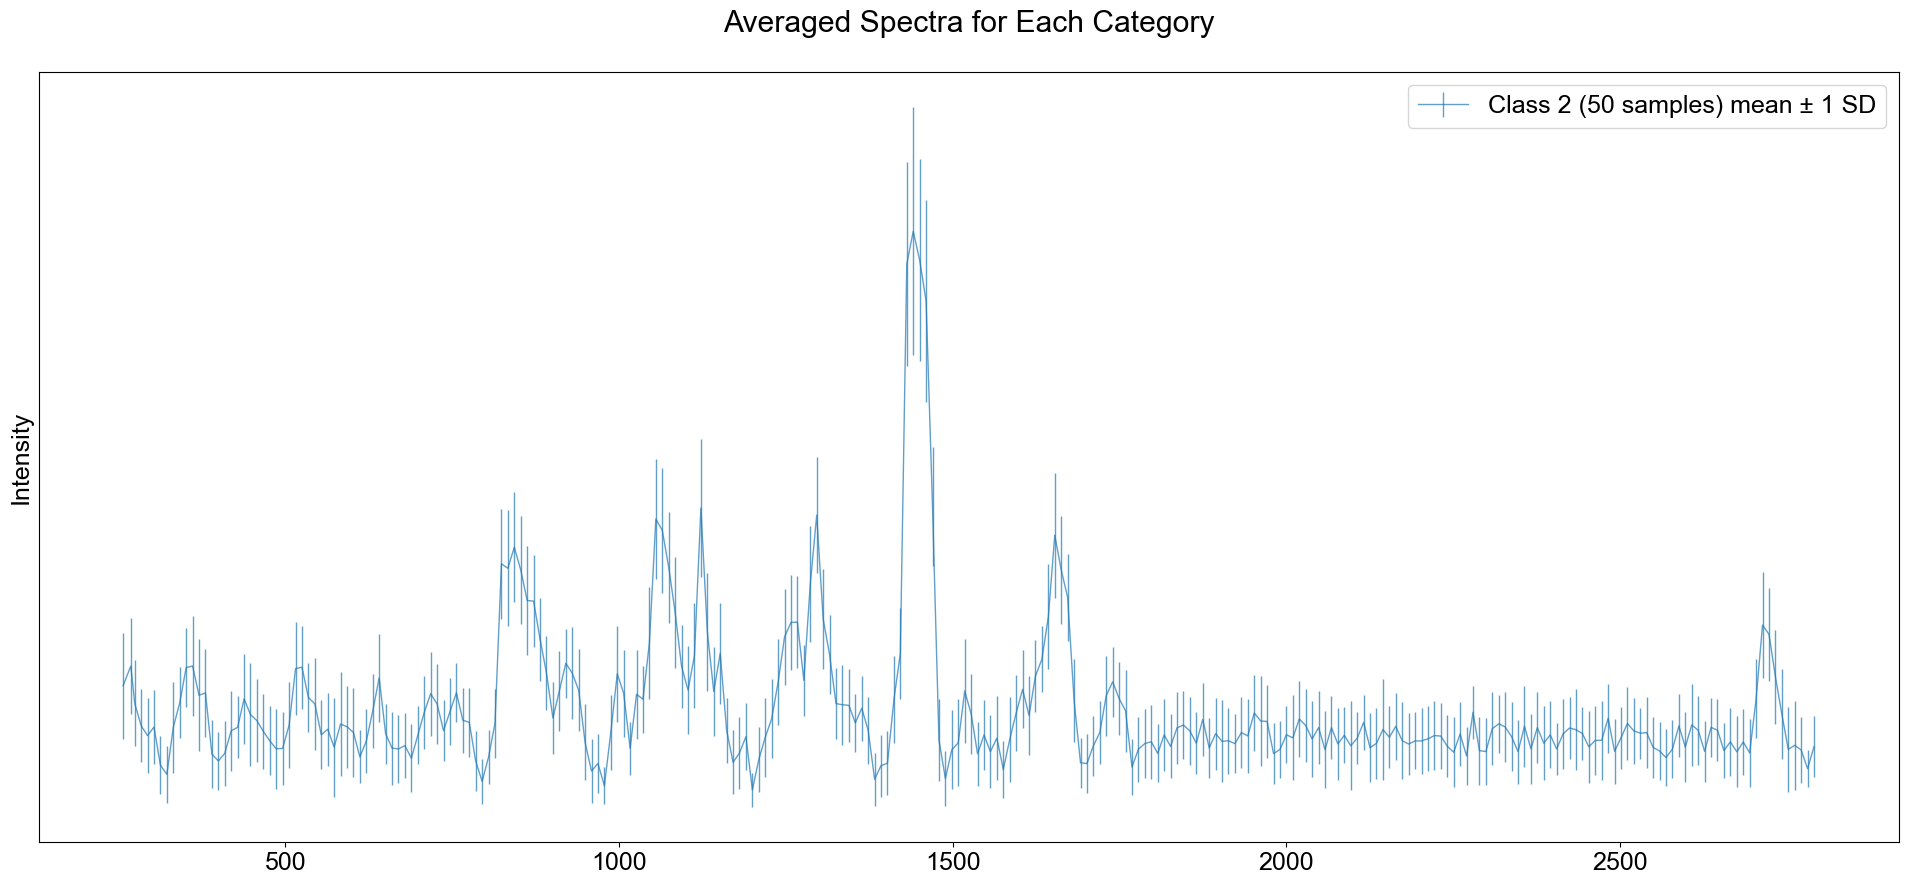

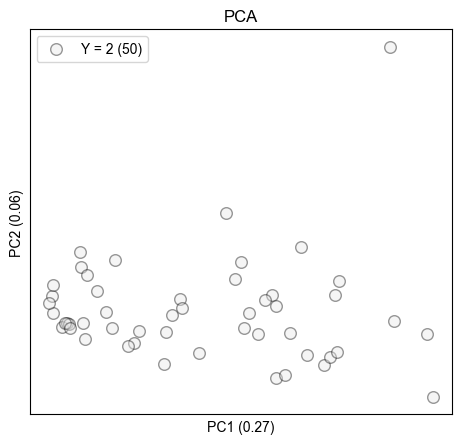

In [83]:
from qsi import io

X, y, X_names, labels = io.open_dataset('G-QHH青海湖牦牛藏酸奶merged_data.CSV',x_range = list(range(104,1426))) # x_range = list(range(100:))

from qsi import pipeline
X, X_names = pipeline.preprocess_dataset(X, X_names, 
                                         pres = [('max', 0.2),('baseline_removal', (1e1, 1e-2))])

io.draw_class_average(X, y, X_names, labels=labels, SD=1, shift=800)

_ = io.scatter_plot(X, y, labels=labels)

In [85]:
X.shape

(50, 264)

In [87]:
select_pts, remaining_pts = kennardstone(X, test_size=0.2, metric='euclidean')

In [89]:
X_train = X[select_pts]
y_train = y[select_pts]

X_test = X[remaining_pts]
y_test = y[remaining_pts]

In [91]:
import numpy as np

# 保存训练集数据
np.savetxt('QHH青海湖牦牛藏酸奶.train_data.csv', X_train, delimiter=',')
np.savetxt('QHH青海湖牦牛藏酸奶.train_labels.csv', y_train, delimiter=',')

# 保存测试集数据
np.savetxt('QHH青海湖牦牛藏酸奶.test_data.csv', X_test, delimiter=',')
np.savetxt('QHH青海湖牦牛藏酸奶.test_labels.csv', y_test, delimiter=',')

X.shape (50, 1322)  y.shape (50,)


窗函数预处理（max）: binning window width =  1 / 0.2 = 5


消除基线飘移: baseline removal (regularization = 10.0, residual penalty asymetry = 0.01)


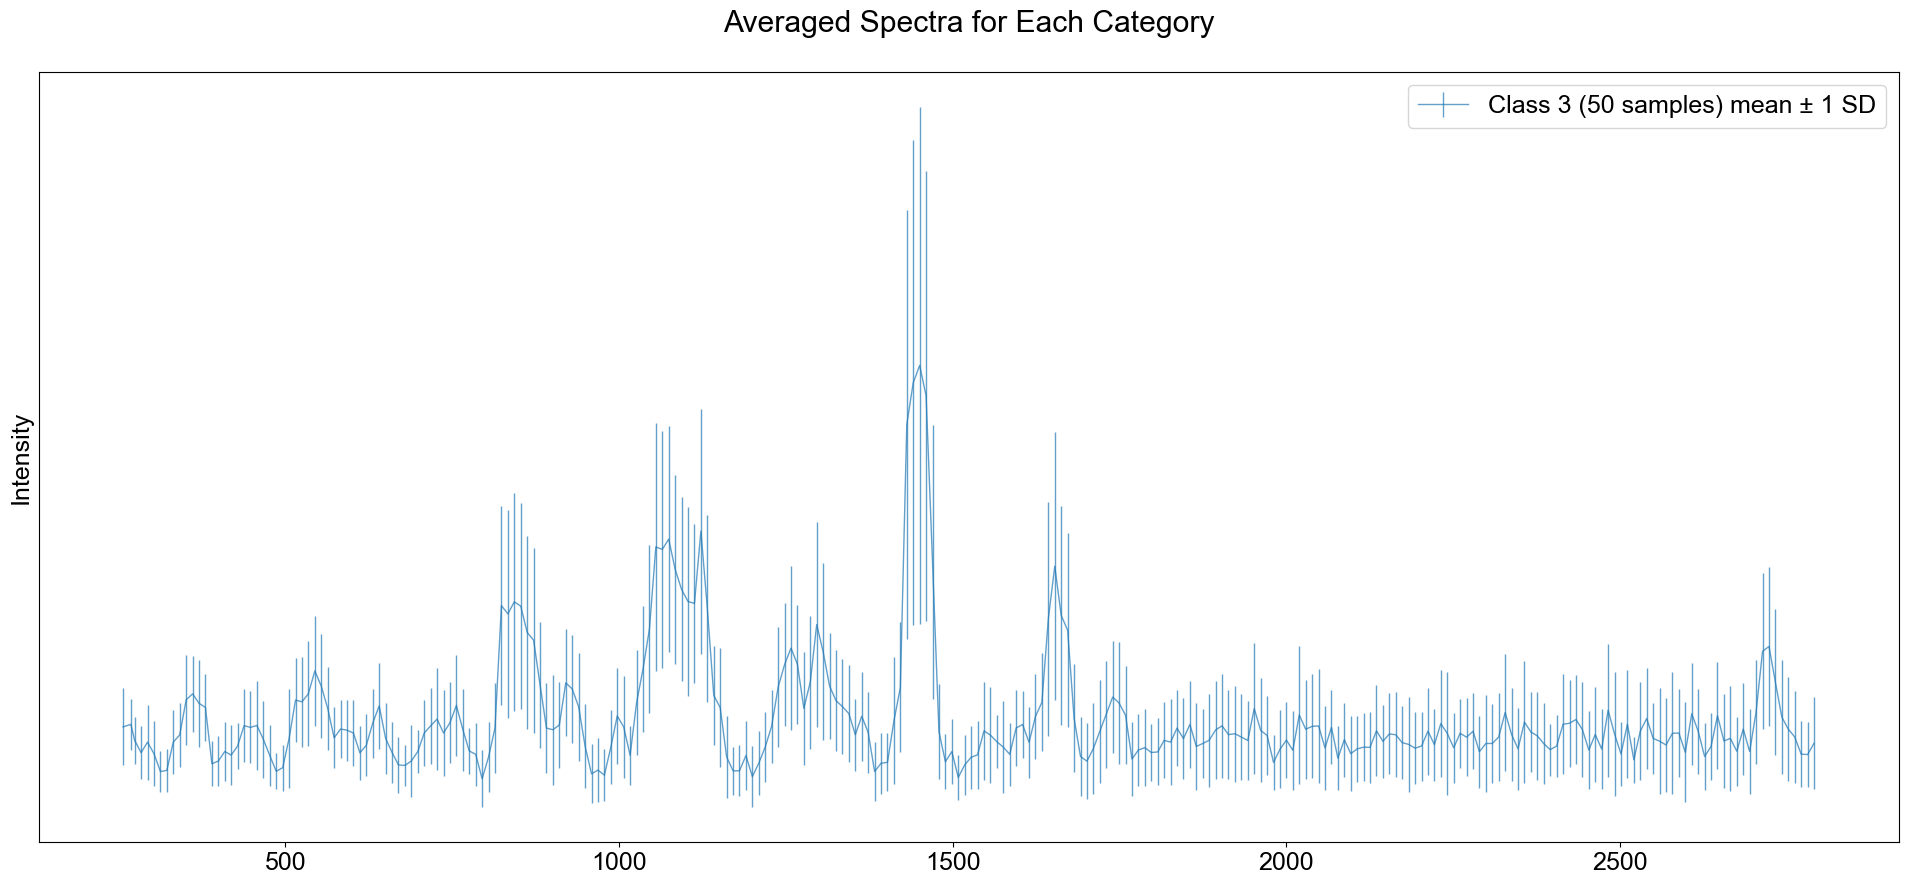

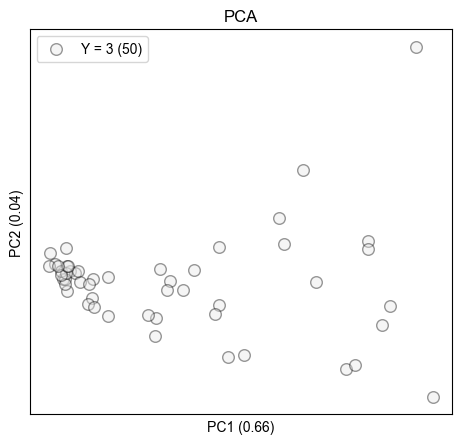

In [109]:
from qsi import io

X, y, X_names, labels = io.open_dataset('G-GY盖元酸羊奶merged_data.CSV',x_range = list(range(104,1426))) # x_range = list(range(100:))

from qsi import pipeline
X, X_names = pipeline.preprocess_dataset(X, X_names, 
                                         pres = [('max', 0.2),('baseline_removal', (1e1, 1e-2))])

io.draw_class_average(X, y, X_names, labels=labels, SD=1, shift=800)

_ = io.scatter_plot(X, y, labels=labels)

In [110]:
X.shape

(50, 264)

In [113]:
select_pts, remaining_pts = kennardstone(X, test_size=0.2, metric='euclidean')

In [115]:
X_train = X[select_pts]
y_train = y[select_pts]

X_test = X[remaining_pts]
y_test = y[remaining_pts]

In [117]:
import numpy as np

# 保存训练集数据
np.savetxt('GY盖元酸羊奶.train_data.csv', X_train, delimiter=',')
np.savetxt('GY盖元酸羊奶.train_labels.csv', y_train, delimiter=',')

# 保存测试集数据
np.savetxt('GY盖元酸羊奶.test_data.csv', X_test, delimiter=',')
np.savetxt('GY盖元酸羊奶.test_labels.csv', y_test, delimiter=',')

In [416]:
train_files = ['CQ畅轻.train_data.csv', 'SNTX水牛同学.train_data.csv', 'QHH青海湖牦牛藏酸奶.train_data.csv', 'GY盖元酸羊奶.train_data.csv']
test_files = ['CQ畅轻.test_data.csv', 'SNTX水牛同学.test_data.csv', 'QHH青海湖牦牛藏酸奶.test_data.csv', 'GY盖元酸羊奶.test_data.csv']
train_label_files = ['CQ畅轻.train_labels.csv', 'SNTX水牛同学.train_labels.csv', 'QHH青海湖牦牛藏酸奶.train_labels.csv', 'GY盖元酸羊奶.train_labels.csv']
test_label_files = ['CQ畅轻.test_labels.csv', 'SNTX水牛同学.test_labels.csv', 'QHH青海湖牦牛藏酸奶.test_labels.csv', 'GY盖元酸羊奶.test_labels.csv']

In [418]:
X_train = []
X_test = []
y_train = []
y_test = []

for train_file, test_file, train_label_file, test_label_file in zip(train_files, test_files, train_label_files, test_label_files):
    train_data = np.loadtxt(train_file, delimiter=',')
    test_data = np.loadtxt(test_file, delimiter=',')
    train_labels = np.loadtxt(train_label_file, delimiter=',')
    test_labels = np.loadtxt(test_label_file, delimiter=',')

    X_train.append(train_data)
    X_test.append(test_data)
    y_train.append(train_labels)
    y_test.append(test_labels)

X_train = np.concatenate(X_train, axis=0)
X_test = np.concatenate(X_test, axis=0)
y_train = np.concatenate(y_train, axis=0)
y_test = np.concatenate(y_test, axis=0)

In [420]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  # 拟合+转换训练集
X_test = scaler.transform(X_test)

In [422]:
print(X_train)
print(y_train)
print(X_test)
print(y_test)

[[0.20287969 0.14445358 0.26510409 ... 0.16290284 0.13122258 0.02998871]
 [0.22558524 0.37613374 0.45129872 ... 0.54757895 0.4151655  0.38819985]
 [0.49691358 0.15562897 0.         ... 0.10471642 0.05289612 0.40859828]
 ...
 [0.11966664 0.17507227 0.02641099 ... 0.04875154 0.26721081 0.19320868]
 [0.35231631 0.35034818 0.02076263 ... 0.08663413 0.08191087 0.02334568]
 [0.04247122 0.14890688 0.10247727 ... 0.05506759 0.17249204 0.08696573]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
[[0.1987669  0.12055316 0.21738578 ... 0.17857435 0.1527039  0.02849

In [424]:
np.savetxt('merged_train_data.csv', X_train, delimiter=',')
np.savetxt('merged_test_data.csv', X_test, delimiter=',')
np.savetxt('merged_train_labels.csv', y_train, delimiter=',')
np.savetxt('merged_test_labels.csv', y_test, delimiter=',')

In [426]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

print(y_train)
print(y_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3]


In [428]:
X_train

array([[0.20287969, 0.14445358, 0.26510409, ..., 0.16290284, 0.13122258,
        0.02998871],
       [0.22558524, 0.37613374, 0.45129872, ..., 0.54757895, 0.4151655 ,
        0.38819985],
       [0.49691358, 0.15562897, 0.        , ..., 0.10471642, 0.05289612,
        0.40859828],
       ...,
       [0.11966664, 0.17507227, 0.02641099, ..., 0.04875154, 0.26721081,
        0.19320868],
       [0.35231631, 0.35034818, 0.02076263, ..., 0.08663413, 0.08191087,
        0.02334568],
       [0.04247122, 0.14890688, 0.10247727, ..., 0.05506759, 0.17249204,
        0.08696573]])

In [133]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import top_k_accuracy_score
import numpy as np
import matplotlib.pyplot as plt
def run_multiclass_clfs_gridsearch(Xs_train, y_train, Xs_test, y_test):
    clfs = [
        GaussianNB(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        LinearSVC(multi_class="crammer_singer"),
        LogisticRegressionCV(multi_class="multinomial", max_iter=1000),
        MLPClassifier(),
        KNeighborsClassifier(),
        LinearDiscriminantAnalysis(),
        ELMClassifier(),
        RVFLClassifier()
    ]

    param_grids = [
        {},
        {'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40]},
        {'n_estimators': list(range(1, max(10, len(set(y_train)))))},
        {'C': [0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 1000]},
        {},
        {'hidden_layer_sizes': [(x,) for x in range(1, 1000, 10)], 'alpha': [0.0001, 0.01, 1]},
        {'n_neighbors': list(range(1, max(5, len(set(y_train)))))},
        {},
        {'n_hidden_nodes': [1, 2, 5, 10, 20, 25, 30, 35, 40, 50, 60, 75, 100, 150, 200]},
        {'n_hidden_nodes': [1, 2, 5, 10, 20, 40, 50, 60, 70, 80, 90, 100]}
    ]
# 初始化一个列表来存储包含混淆矩阵和分类器名称的字典
    confusion_matrix_results = []
    dic_train_accs = {}
    dic_test_accs = {}

    kfold = KFold(n_splits=3, shuffle=True, random_state=20)

    for i, (clf, param_grid) in enumerate(zip(clfs, param_grids)):
        np.random.seed(20)  # 设置随机种子
        gs = GridSearchCV(clf, param_grid, cv=kfold, n_jobs=1, verbose=0)
        gs.fit(Xs_train, y_train)

        clf = gs.best_estimator_
        clf_name = str(clf)
        
        dic_train_accs[clf_name] = [clf.score(Xs_train, y_train)]
        y_pred_train = clf.predict(Xs_train)
        train_cm = confusion_matrix(y_train, y_pred_train)
        print(f"{clf_name} Training Set Confusion Matrix:")
        print(train_cm)
        if len(set(y_train)) >= 8:
            y_score_train = clf.predict_proba(Xs_train)
            y_score_train = np.nan_to_num(y_score_train)
            dic_train_accs[clf_name].append(top_k_accuracy_score(y_train, y_score_train, k=3))
            dic_train_accs[clf_name].append(top_k_accuracy_score(y_train, y_score_train, k=5))

        dic_test_accs[clf_name] = [clf.score(Xs_test, y_test)]
        y_pred_test = clf.predict(Xs_test)
        test_cm = confusion_matrix(y_test, y_pred_test)
        print(f"{clf_name} Test Set Confusion Matrix:")
        print(test_cm)
        if len(set(y_train)) >= 8:
            y_score_test = clf.predict_proba(Xs_test)
            y_score_test = np.nan_to_num(y_score_test)
            dic_test_accs[clf_name].append(top_k_accuracy_score(y_test, y_score_test, k=3))
            dic_test_accs[clf_name].append(top_k_accuracy_score(y_test, y_score_test, k=5))
                        
        # 创建一个包含混淆矩阵和分类器名称的字典
        confusion_matrix_dict = {
            'classifier_name': str(clf),
            'train_cm': train_cm,
            'test_cm': test_cm
        }

        # 将字典添加到列表中
        confusion_matrix_results.append(confusion_matrix_dict)

        print(clf_name)
        print("Training set:")
        print("Top-1 accuracy:", format(dic_train_accs[clf_name][0], '.5f'))
        if len(set(y_train)) >= 8:
            print("Top-3 accuracy:", format(dic_train_accs[clf_name][1], '.5f'))
            print("Top-5 accuracy:", format(dic_train_accs[clf_name][2], '.5f'))

        print("Test set:")
        print("Top-1 accuracy:", format(dic_test_accs[clf_name][0], '.5f'))
        if len(set(y_train)) >= 8:
            print("Top-3 accuracy:", format(dic_test_accs[clf_name][1], '.5f'))
            print("Top-5 accuracy:", format(dic_test_accs[clf_name][2], '.5f'))   
        print("")

        # Plot confusion matrix and normalized confusion matrix for train set
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        # 修改点2：替换原 plot_confusion_matrix 绘制训练集未归一化混淆矩阵
        train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=clf.classes_)
        train_disp.plot(ax=ax[0], cmap='Blues')
        ax[0].set_title('Train Set - Confusion Matrix')

        # 修改点3：替换原 plot_confusion_matrix 绘制训练集归一化混淆矩阵
        train_disp_normalized = ConfusionMatrixDisplay(confusion_matrix=train_cm / train_cm.sum(axis=1)[:, np.newaxis],
                                                       display_labels=clf.classes_)
        train_disp_normalized.plot(ax=ax[1], cmap='Blues')
        ax[1].set_title('Train Set - Normalized Confusion Matrix')
        plt.show()

        # Plot confusion matrix and normalized confusion matrix for test set
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        # 修改点4：替换原 plot_confusion_matrix 绘制测试集未归一化混淆矩阵
        test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=clf.classes_)
        test_disp.plot(ax=ax[0], cmap='Blues')
        ax[0].set_title('Test Set - Confusion Matrix')

        # 修改点5：替换原 plot_confusion_matrix 绘制测试集归一化混淆矩阵
        test_disp_normalized = ConfusionMatrixDisplay(confusion_matrix=test_cm / test_cm.sum(axis=1)[:, np.newaxis],
                                                      display_labels=clf.classes_)
        test_disp_normalized.plot(ax=ax[1], cmap='Blues')
        ax[1].set_title('Test Set - Normalized Confusion Matrix')
        plt.show()

        
        
        
        # 遍历列表，处理每个模型的混淆矩阵
    for result in confusion_matrix_results:
        classifier_name = result['classifier_name']
        train_cm = result['train_cm']
        test_cm = result['test_cm']

        # 初始化类别指标列表
        category_train_precisions = []
        category_train_recalls = []
        category_train_f1_scores = []
        category_train_accuracies = []
        category_test_precisions = []
        category_test_recalls = []
        category_test_f1_scores = []
        category_test_accuracies = []
         # 计算训练集和测试集的每个类别的指标
        for i in range(4):
            train_TP = train_cm[i][i]
            train_FP = sum([j[i] for j in train_cm]) - train_TP
            train_FN = sum(train_cm[i]) - train_TP

            test_TP = test_cm[i][i]
            test_FP = sum([j[i] for j in test_cm]) - test_TP
            test_FN = sum(test_cm[i]) - test_TP

            train_precision = train_TP / (train_TP + train_FP) if (train_TP + train_FP) > 0 else 0
            train_recall = train_TP / (train_TP + train_FN) if (train_TP + train_FN) > 0 else 0
            train_f1 = (2 * train_precision * train_recall) / (train_precision + train_recall) if (train_precision + train_recall) > 0 else 0
            train_accuracy = train_TP / sum(train_cm[i]) if sum(train_cm[i]) > 0 else 0

            test_precision = test_TP / (test_TP + test_FP) if (test_TP + test_FP) > 0 else 0
            test_recall = test_TP / (test_TP + test_FN) if (test_TP + test_FN) > 0 else 0
            test_f1 = (2 * test_precision * test_recall) / (test_precision + test_recall) if (test_precision + test_recall) > 0 else 0
            test_accuracy = test_TP / sum(test_cm[i]) if sum(test_cm[i]) > 0 else 0


            # 将结果添加到相应的列表中
            category_train_precisions.append(train_precision)
            category_train_recalls.append(train_recall)
            category_train_f1_scores.append(train_f1)
            category_train_accuracies.append(train_accuracy)
            category_test_precisions.append(test_precision)
            category_test_recalls.append(test_recall)
            category_test_f1_scores.append(test_f1)
            category_test_accuracies.append(test_accuracy)

        # 计算并打印模型的总体平均指标
        print(f"{classifier_name} 训练集总体平均准确率（Accuracy）: {sum(category_train_accuracies) / 4:.5f}")
        print(f"{classifier_name} 训练集总体平均精确率（Precision）: {sum(category_train_precisions) / 4:.5f}")
        print(f"{classifier_name} 训练集总体平均召回率（Recall）: {sum(category_train_recalls) / 4:.5f}")
        print(f"{classifier_name} 训练集总体平均F1分数（F1 Score）: {sum(category_train_f1_scores) / 4:.5f}\n")

        print(f"{classifier_name} 测试集总体平均准确率（Accuracy）: {sum(category_test_accuracies) / 4:.5f}")
        print(f"{classifier_name} 测试集总体平均精确率（Precision）: {sum(category_test_precisions) / 4:.5f}")
        print(f"{classifier_name} 测试集总体平均召回率（Recall）: {sum(category_test_recalls) / 4:.5f}")
        print(f"{classifier_name} 测试集总体平均F1分数（F1 Score）: {sum(category_test_f1_scores) / 4:.5f}\n")
        
        
        
        
    return dic_train_accs, dic_test_accs

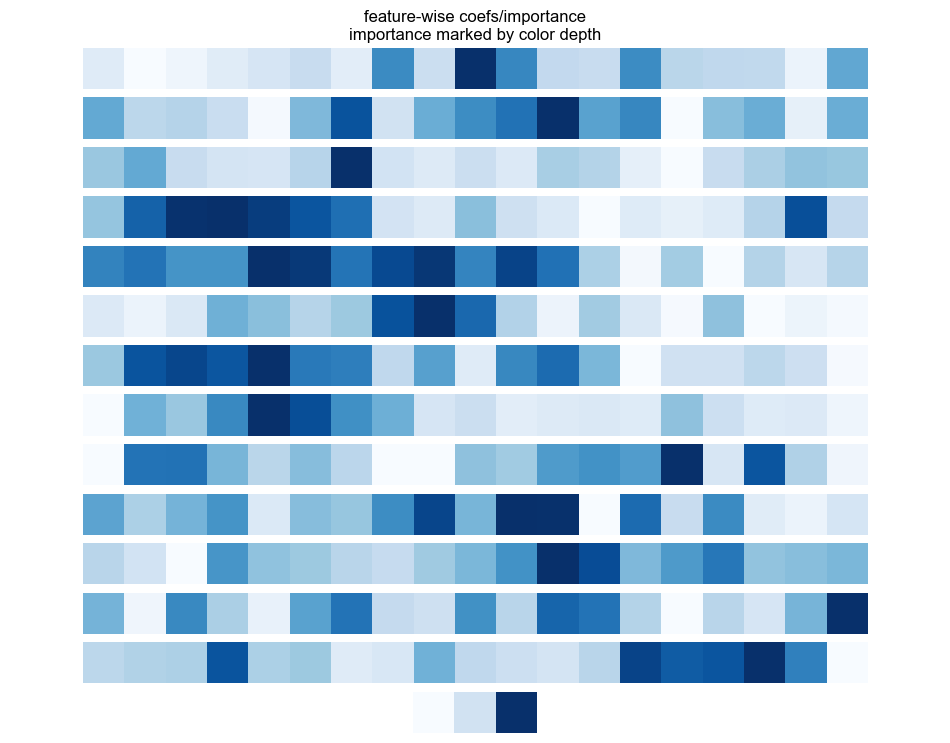

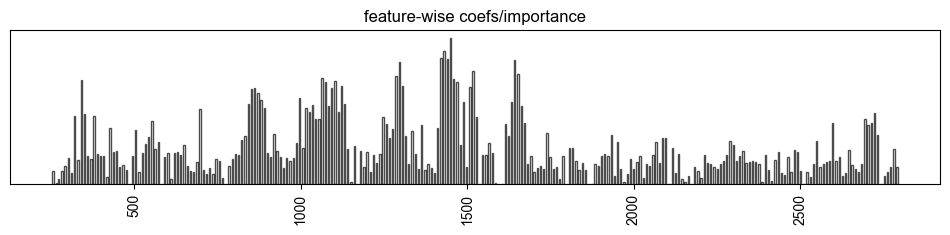

Important feature Number:  10
Important features indices:  [124 122 121 123 144 108 131 145 107  84]
Important features names:  [1450.396 1431.112 1421.469 1440.754 1643.243 1296.119 1517.893 1652.885
 1286.477 1064.703]
Top-10 feature Importance:  [0.82049704 0.74768279 0.70821754 0.70099164 0.69801297 0.68279674
 0.63190533 0.61844569 0.60477422 0.59709512]


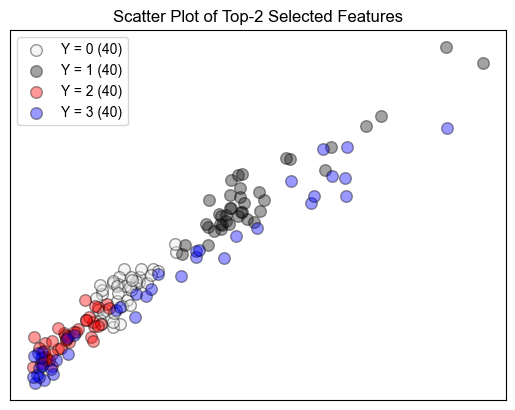

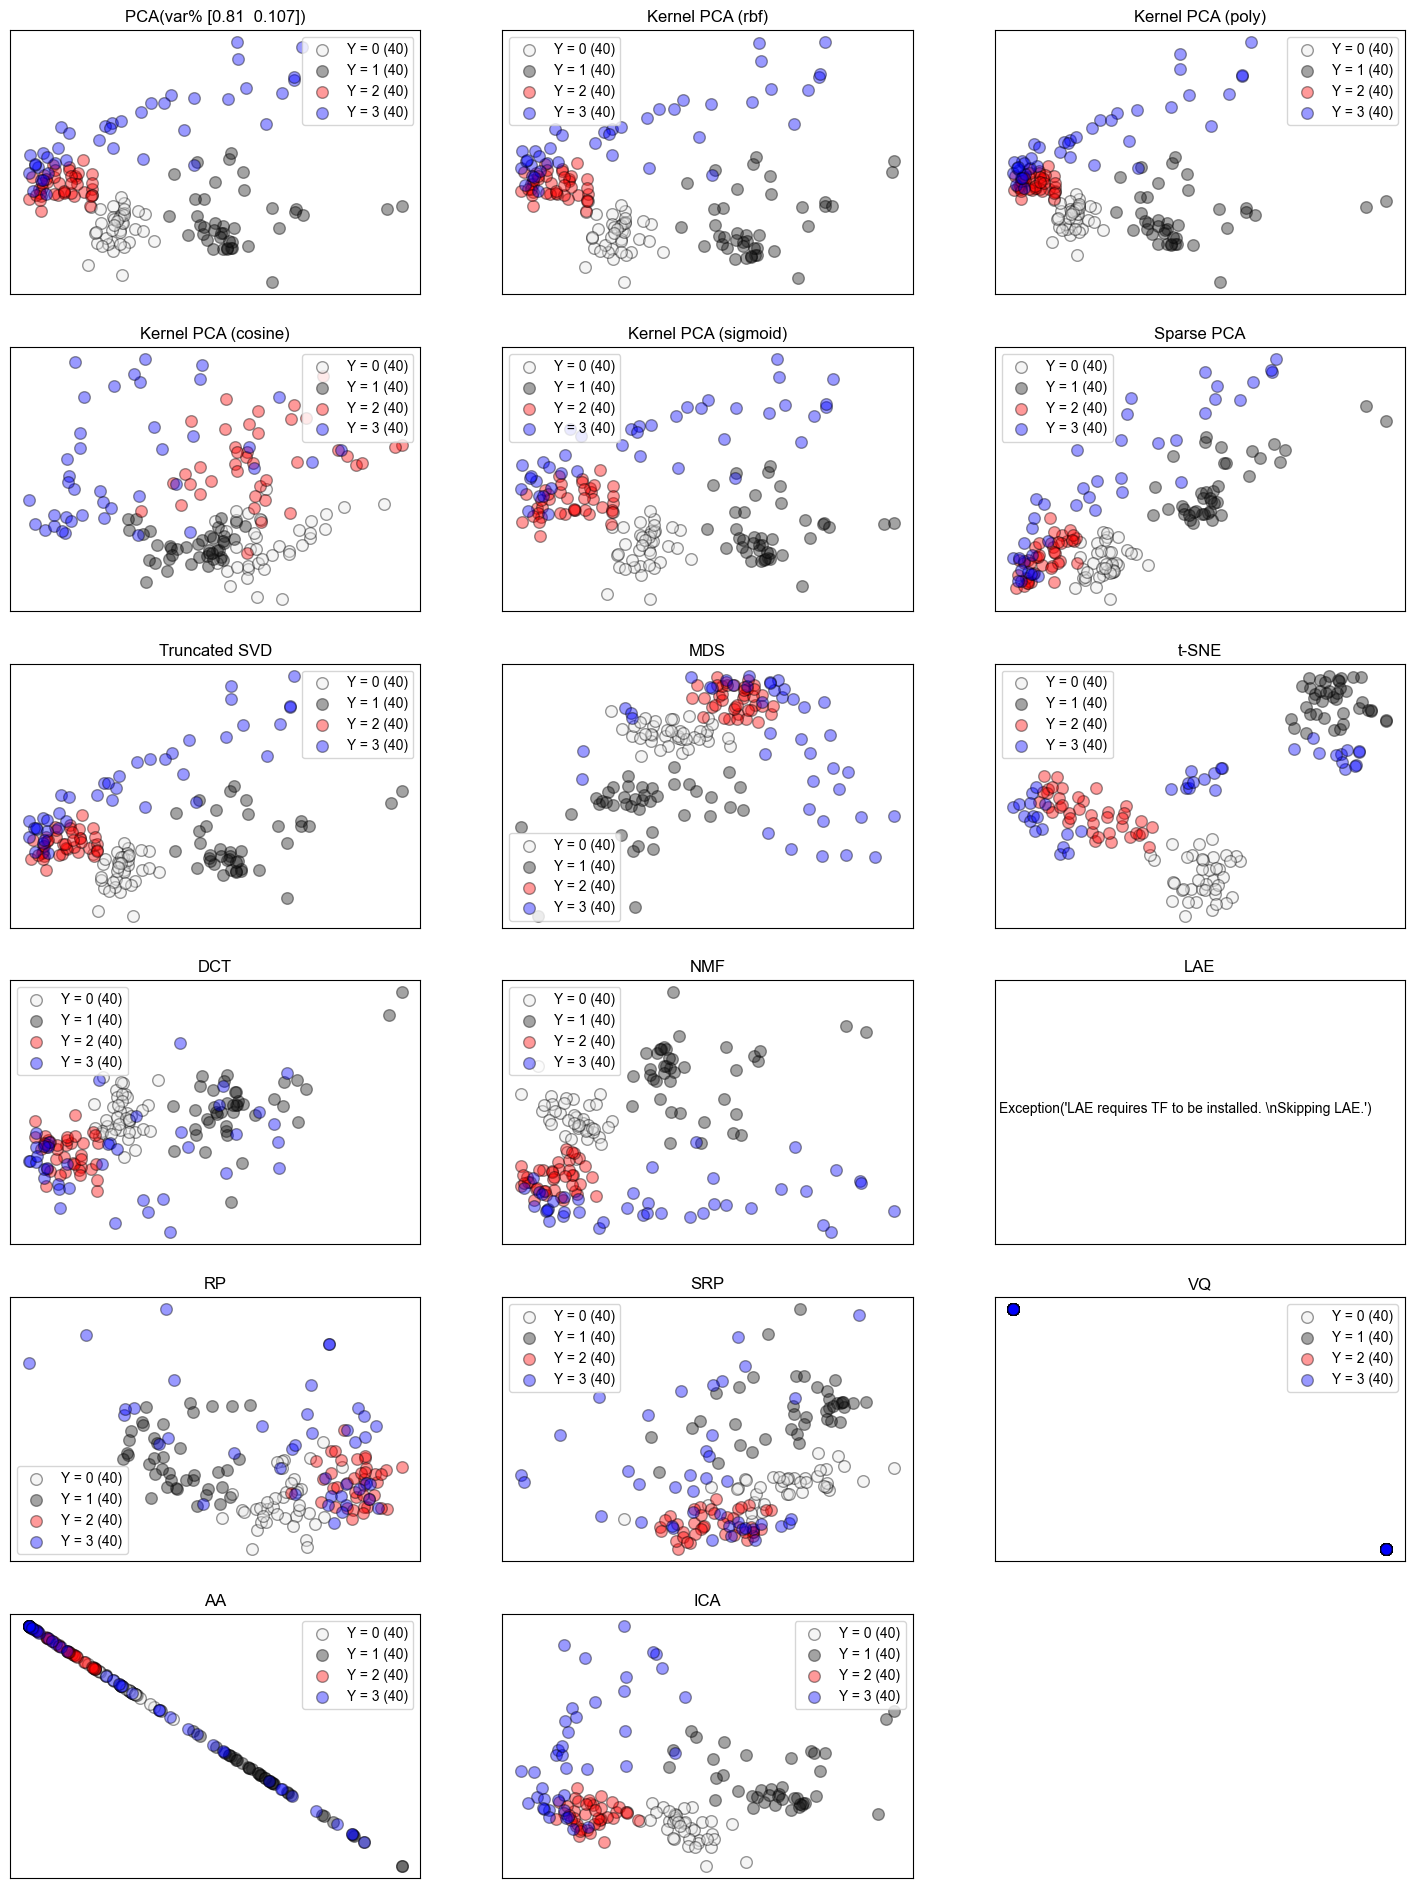

Classification accurary with the selected features (LogisticRegressionCV) =  0.981


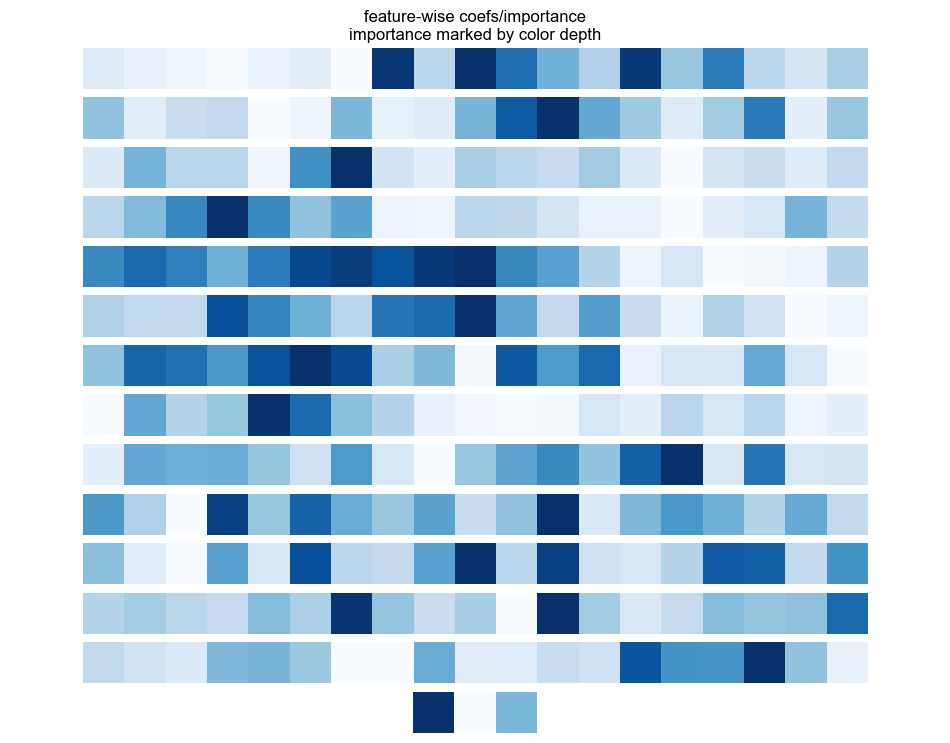

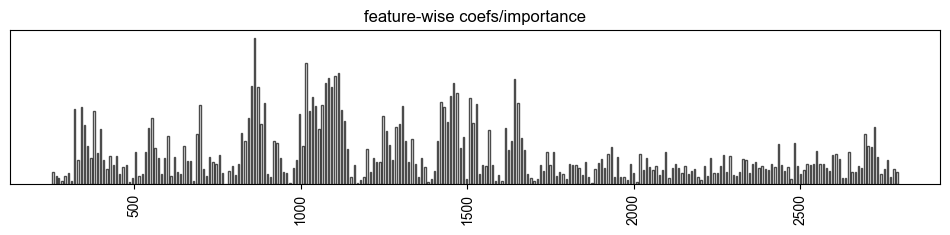

Important feature Number:  10
Important features indices:  [ 63  79  89  88  86 144 125  85  62  87]
Important features names:  [ 862.214  1016.491  1112.915  1103.272  1083.988  1643.243  1460.039
 1074.345   852.5717 1093.63  ]
Top-10 feature Importance:  [22.91739436 18.91299627 17.42848149 16.88078043 16.5702476  16.39945044
 15.84711118 15.81338512 15.36227663 15.21209203]


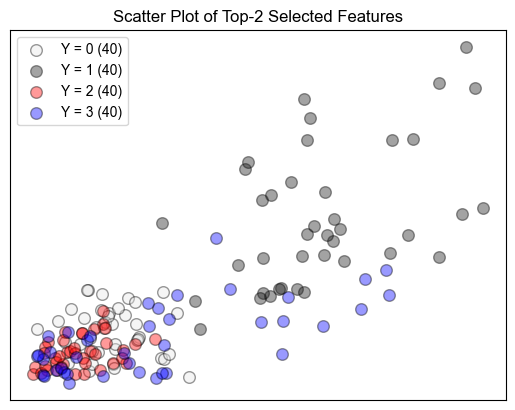

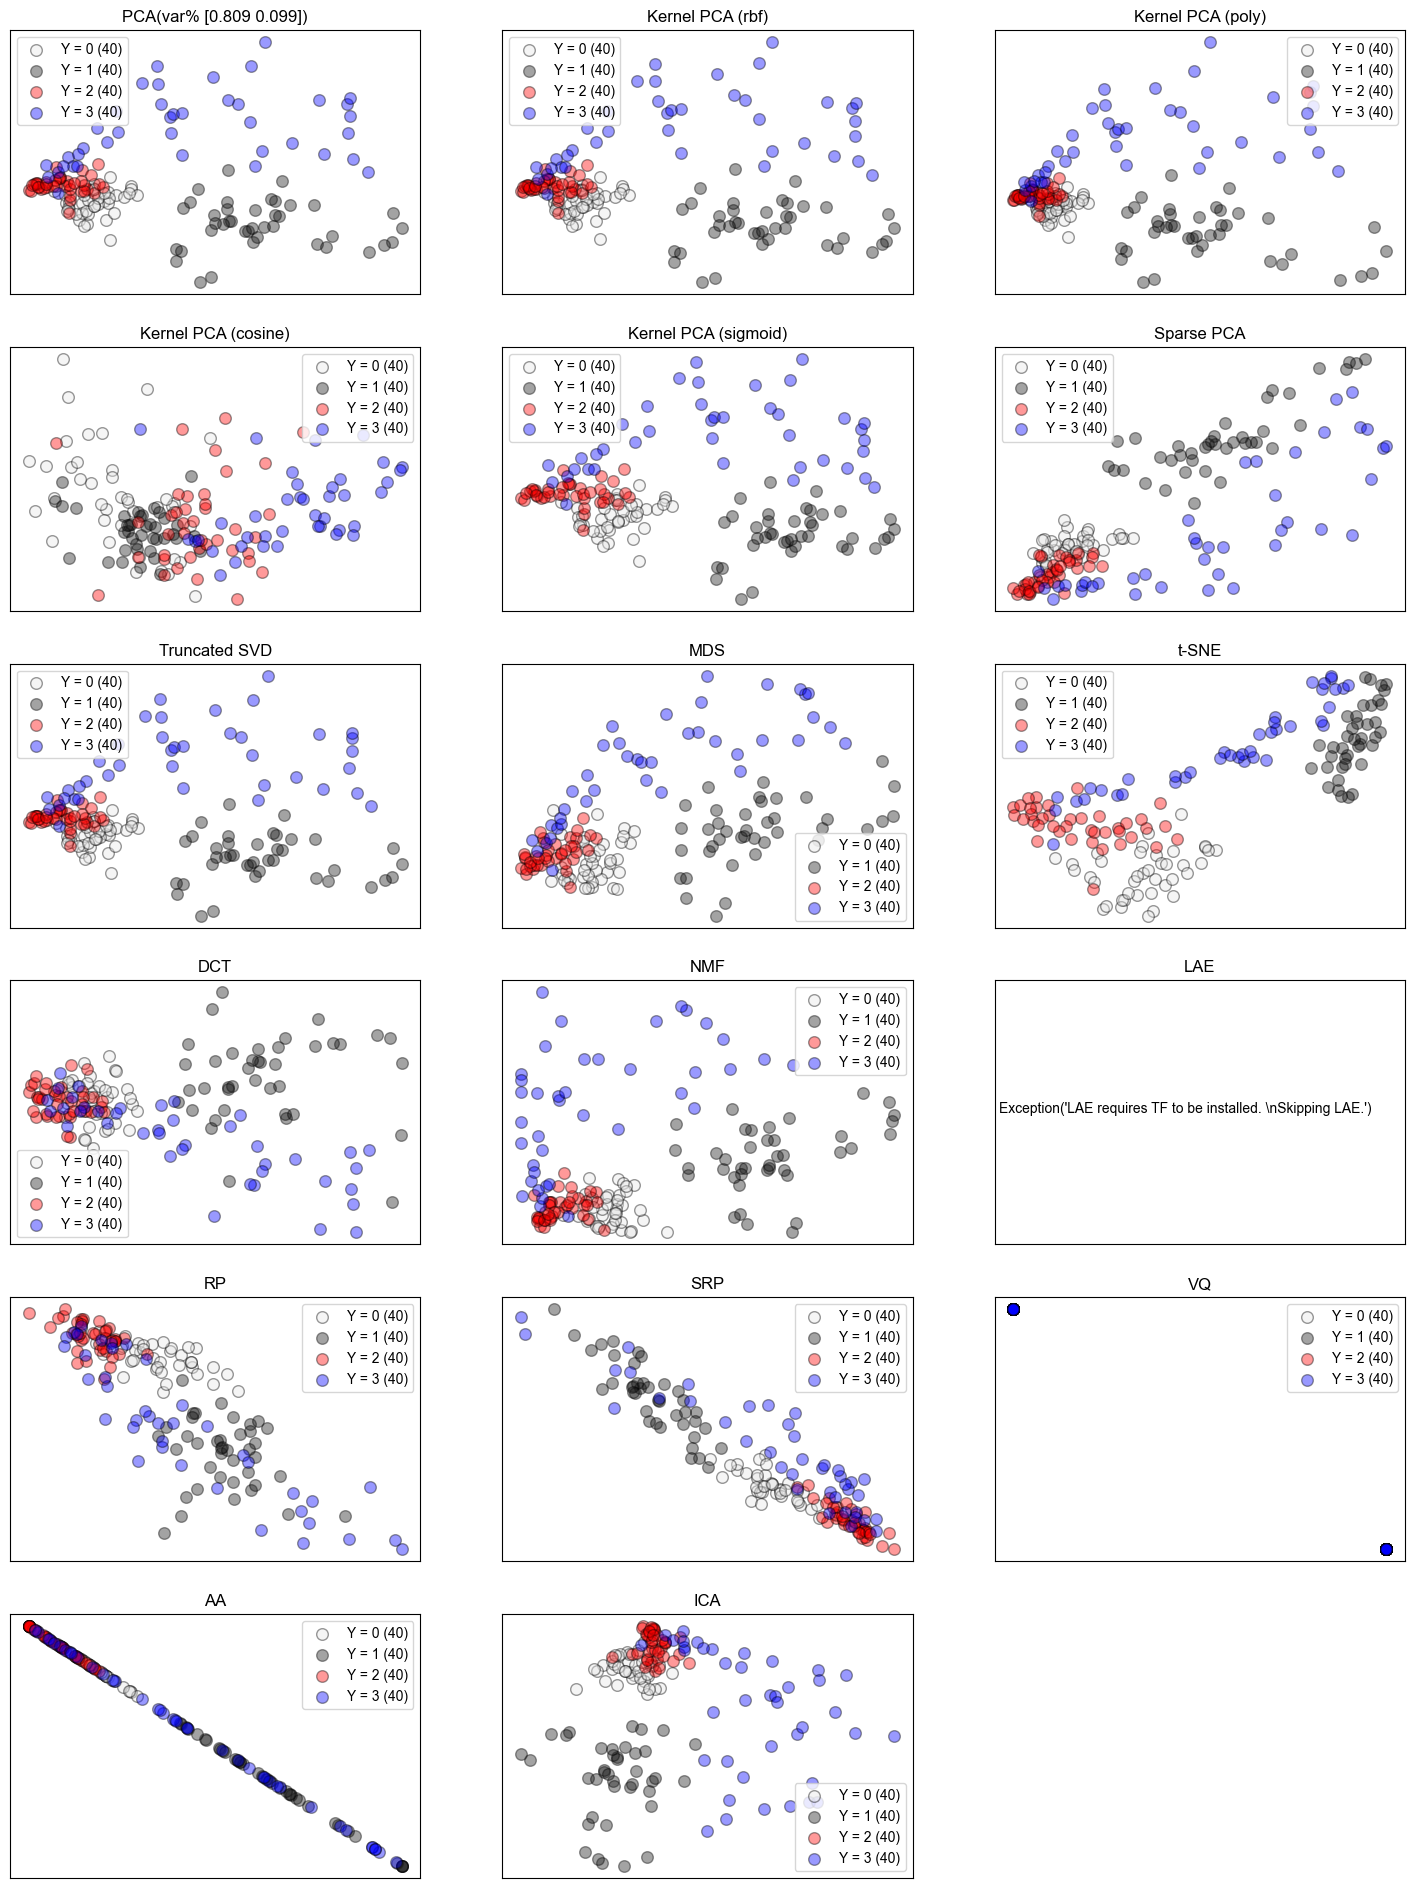

Classification accurary with the selected features (LogisticRegressionCV) =  0.9


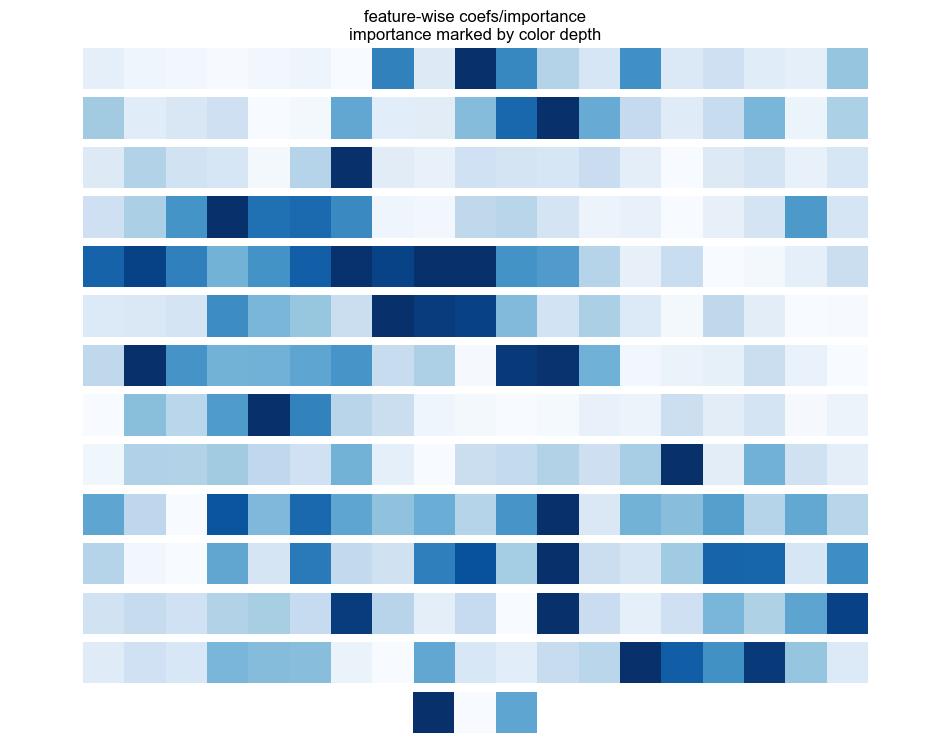

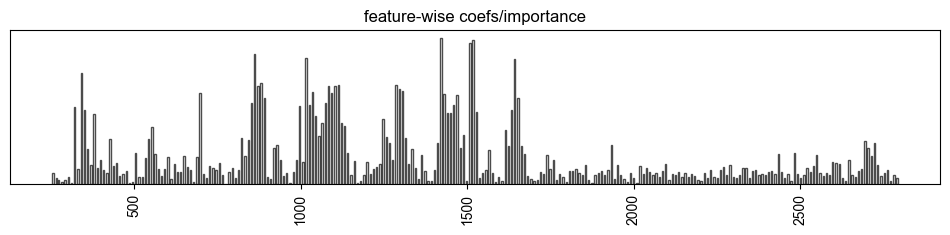

Important feature Number:  10
Important features indices:  [121 131 130  63  79 144   9  65 107  89]
Important features names:  [1421.469  1517.893  1508.25    862.214  1016.491  1643.243   341.5279
  881.4987 1286.477  1112.915 ]
Top-10 feature Importance:  [104.97458768 103.61137677 101.20240407  93.45216379  90.38500295
  89.5534185   79.59919748  72.83951019  71.26919216  70.70863341]


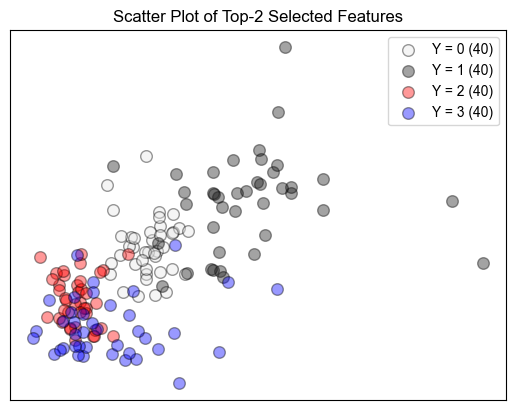

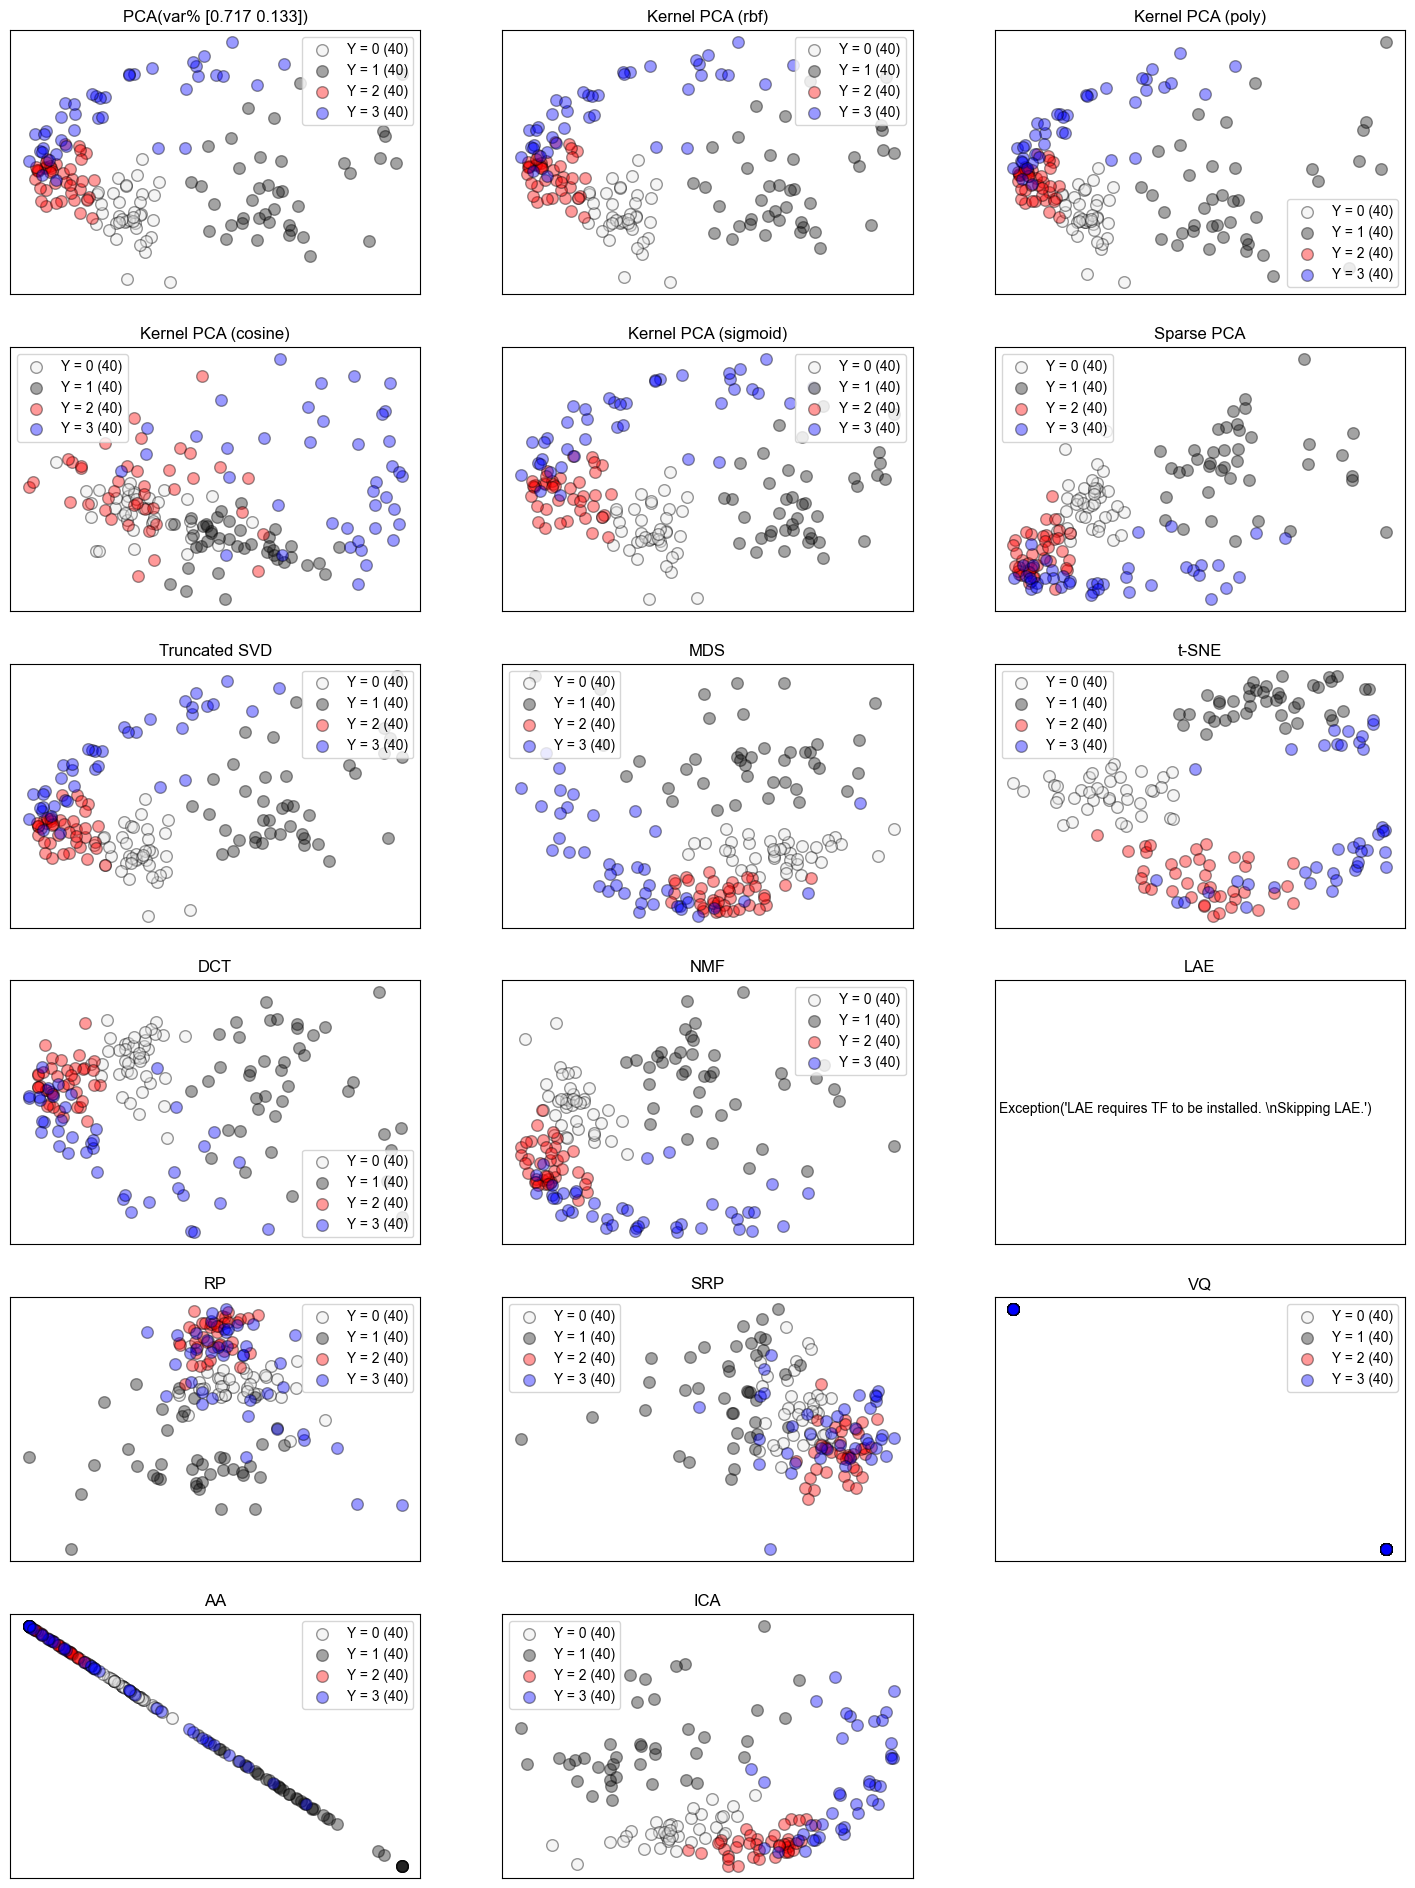

Classification accurary with the selected features (LogisticRegressionCV) =  1.0


In [135]:
from qsi.fs import RUN_ALL_FS
from sklearn.preprocessing import StandardScaler,MinMaxScaler
plt.rcParams['font.family'] = 'Arial'


X_s, _, FS_IDX = RUN_ALL_FS(X_train, y_train, X_names, N = 10, output='all')

GaussianNB() Training Set Confusion Matrix:
[[40  0  0  0]
 [ 0 40  0  0]
 [ 0  0 40  0]
 [ 0  3 12 25]]
GaussianNB() Test Set Confusion Matrix:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  6  4]]
GaussianNB()
Training set:
Top-1 accuracy: 0.90625
Test set:
Top-1 accuracy: 0.85000



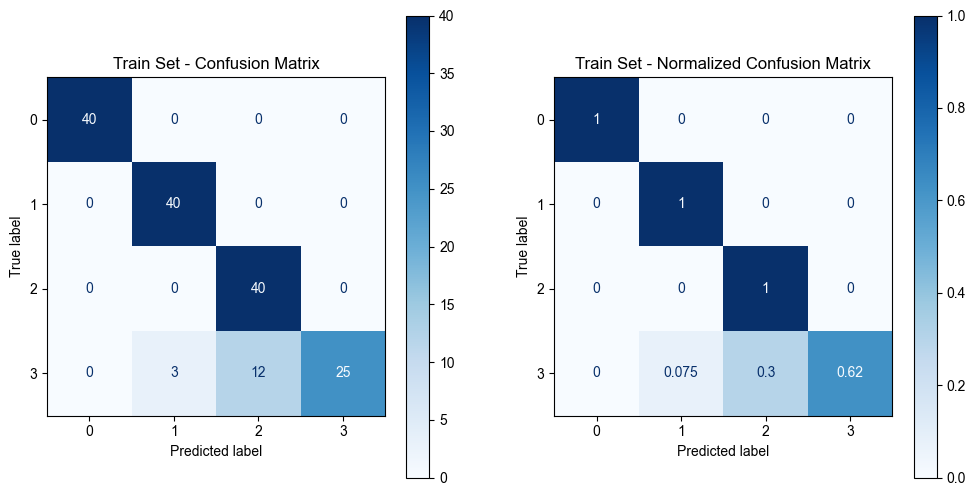

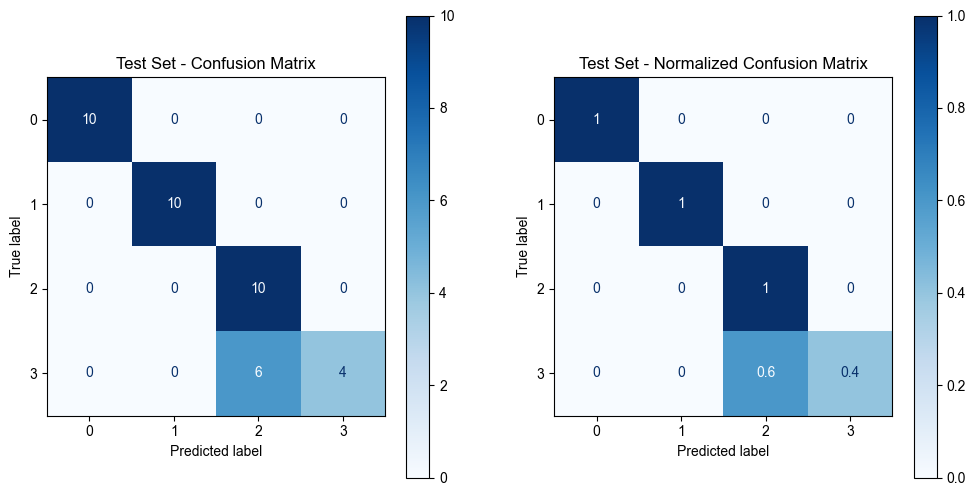

DecisionTreeClassifier(max_depth=40) Training Set Confusion Matrix:
[[40  0  0  0]
 [ 0 40  0  0]
 [ 0  0 40  0]
 [ 0  0  0 40]]
DecisionTreeClassifier(max_depth=40) Test Set Confusion Matrix:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  1  9]]
DecisionTreeClassifier(max_depth=40)
Training set:
Top-1 accuracy: 1.00000
Test set:
Top-1 accuracy: 0.97500



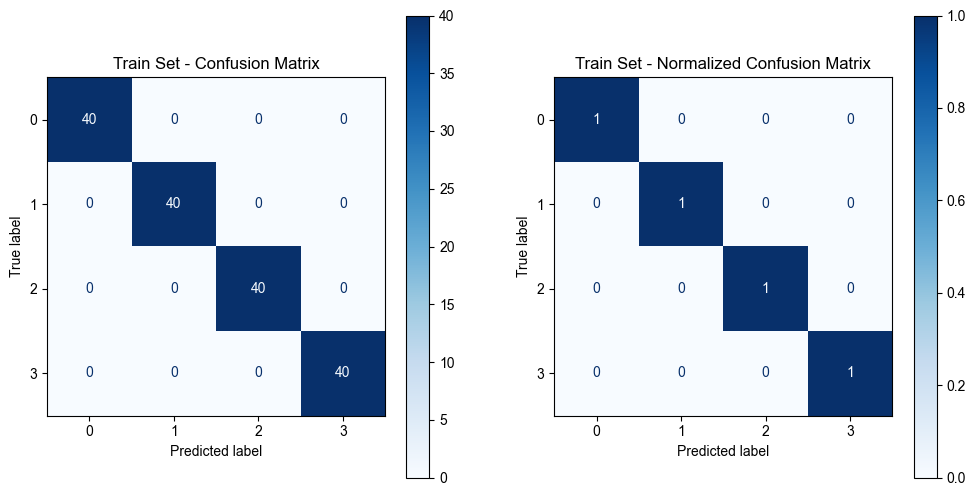

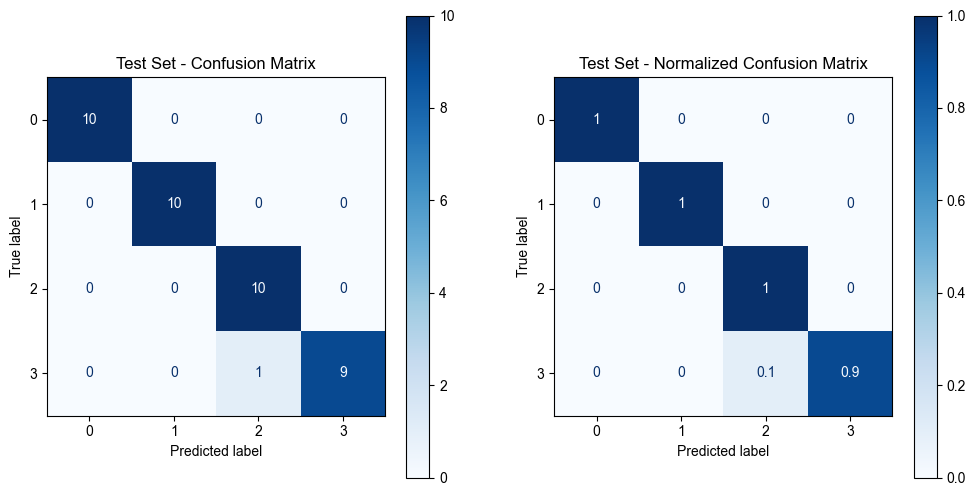

RandomForestClassifier(n_estimators=9) Training Set Confusion Matrix:
[[40  0  0  0]
 [ 0 40  0  0]
 [ 0  0 40  0]
 [ 0  0  0 40]]
RandomForestClassifier(n_estimators=9) Test Set Confusion Matrix:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]
RandomForestClassifier(n_estimators=9)
Training set:
Top-1 accuracy: 1.00000
Test set:
Top-1 accuracy: 1.00000



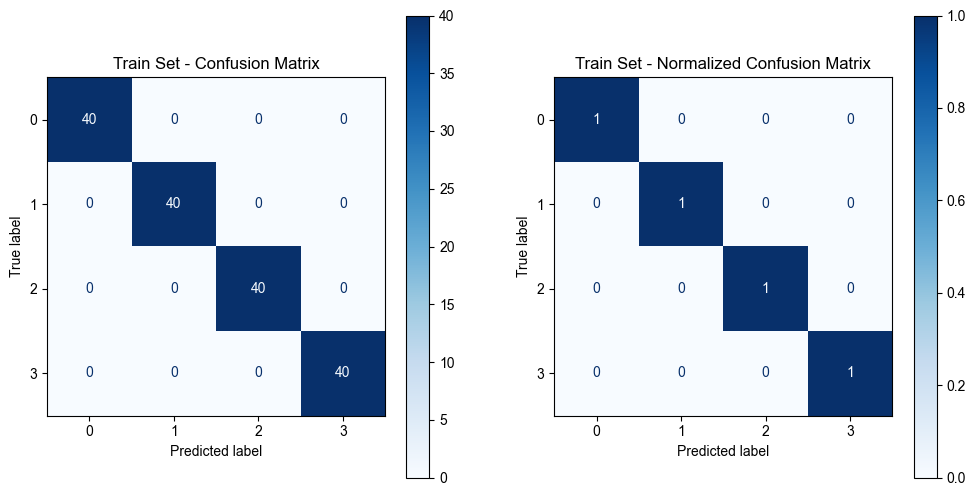

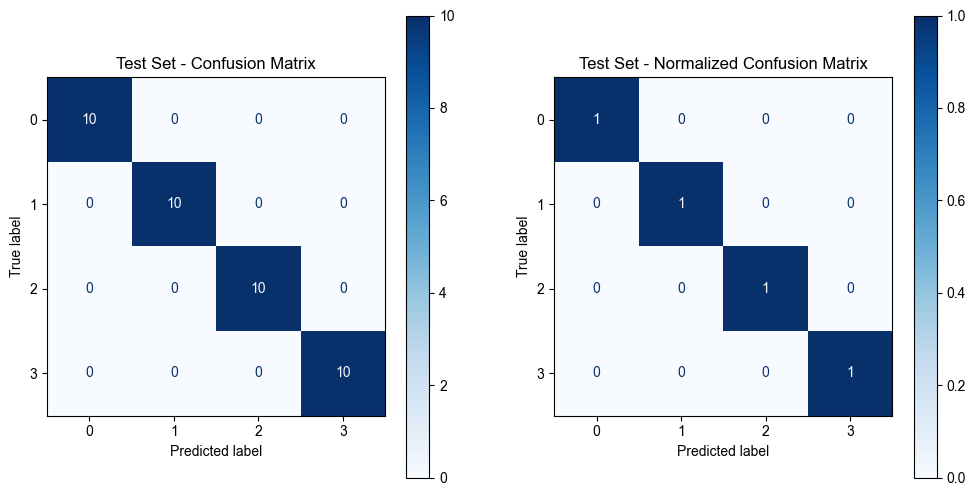

LinearSVC(C=100, multi_class='crammer_singer') Training Set Confusion Matrix:
[[40  0  0  0]
 [ 0 40  0  0]
 [ 0  0 39  1]
 [ 0  0  2 38]]
LinearSVC(C=100, multi_class='crammer_singer') Test Set Confusion Matrix:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  1  9]]
LinearSVC(C=100, multi_class='crammer_singer')
Training set:
Top-1 accuracy: 0.98125
Test set:
Top-1 accuracy: 0.97500



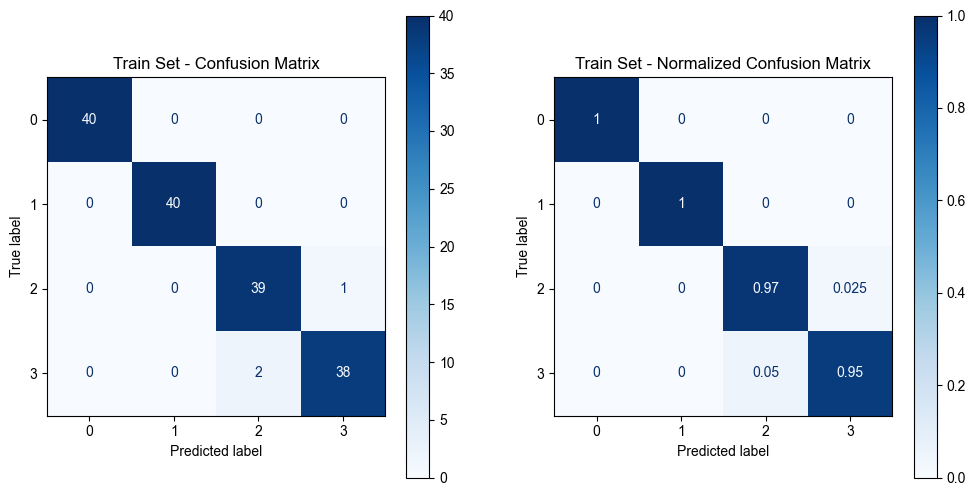

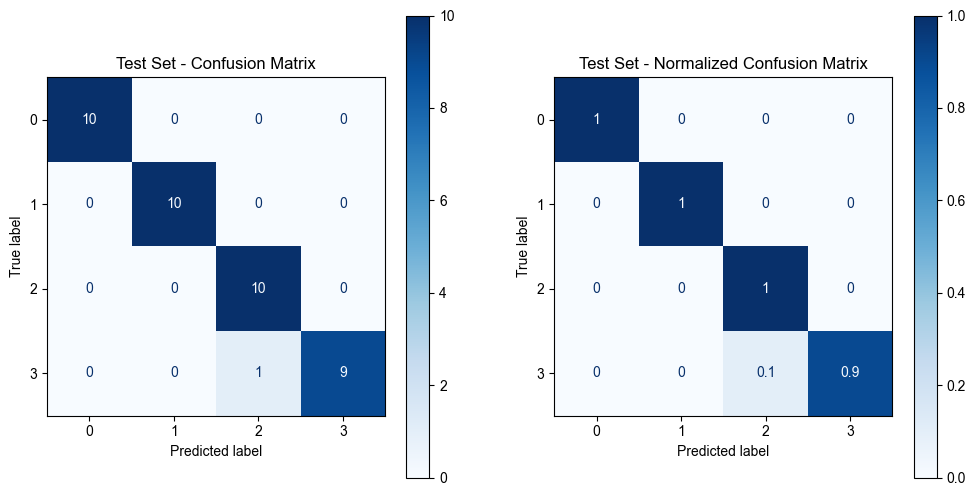

LogisticRegressionCV(max_iter=1000, multi_class='multinomial') Training Set Confusion Matrix:
[[40  0  0  0]
 [ 0 40  0  0]
 [ 0  0 40  0]
 [ 0  0  0 40]]
LogisticRegressionCV(max_iter=1000, multi_class='multinomial') Test Set Confusion Matrix:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  1  9]]
LogisticRegressionCV(max_iter=1000, multi_class='multinomial')
Training set:
Top-1 accuracy: 1.00000
Test set:
Top-1 accuracy: 0.97500



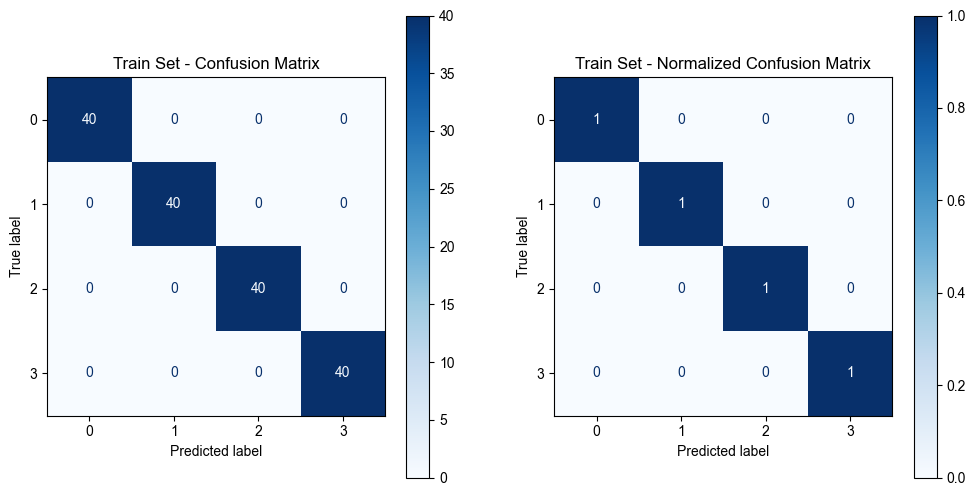

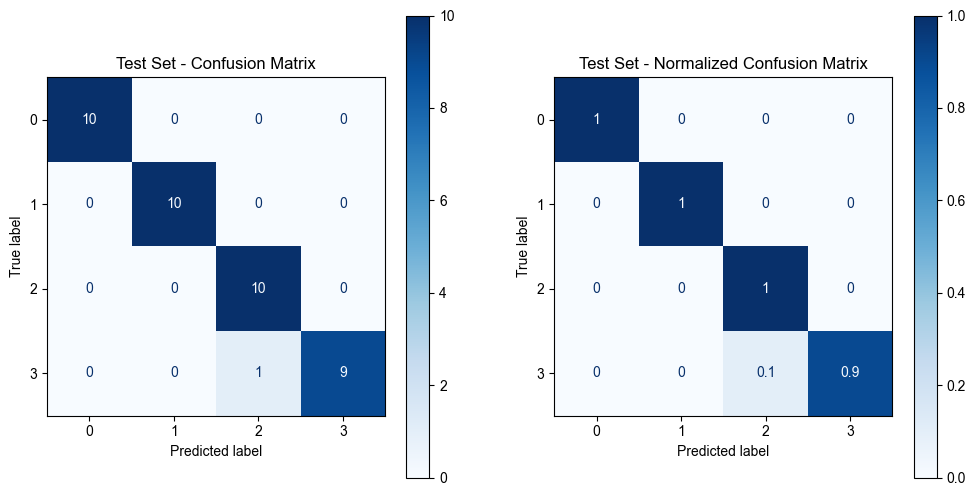

MLPClassifier(alpha=1, hidden_layer_sizes=(651,)) Training Set Confusion Matrix:
[[39  0  0  1]
 [ 0 40  0  0]
 [ 0  0 38  2]
 [ 0  0  7 33]]
MLPClassifier(alpha=1, hidden_layer_sizes=(651,)) Test Set Confusion Matrix:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  2  8]]
MLPClassifier(alpha=1, hidden_layer_sizes=(651,))
Training set:
Top-1 accuracy: 0.93750
Test set:
Top-1 accuracy: 0.95000



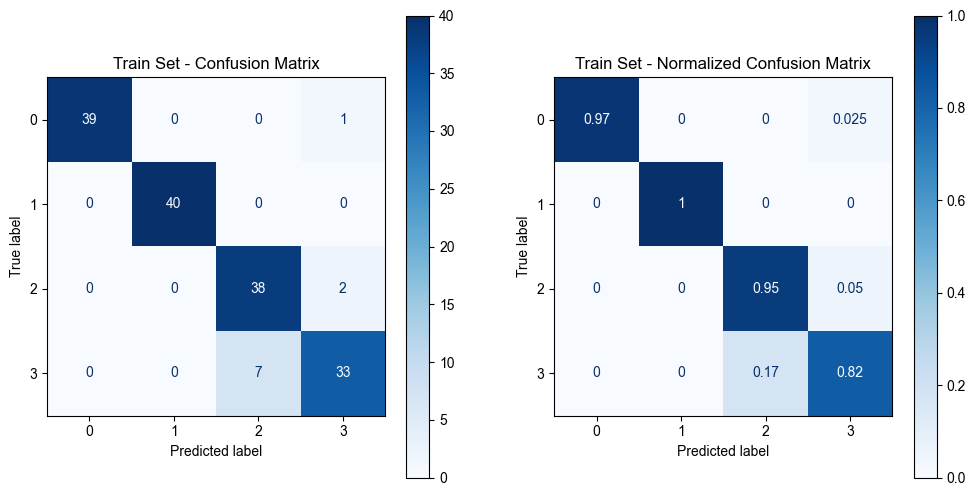

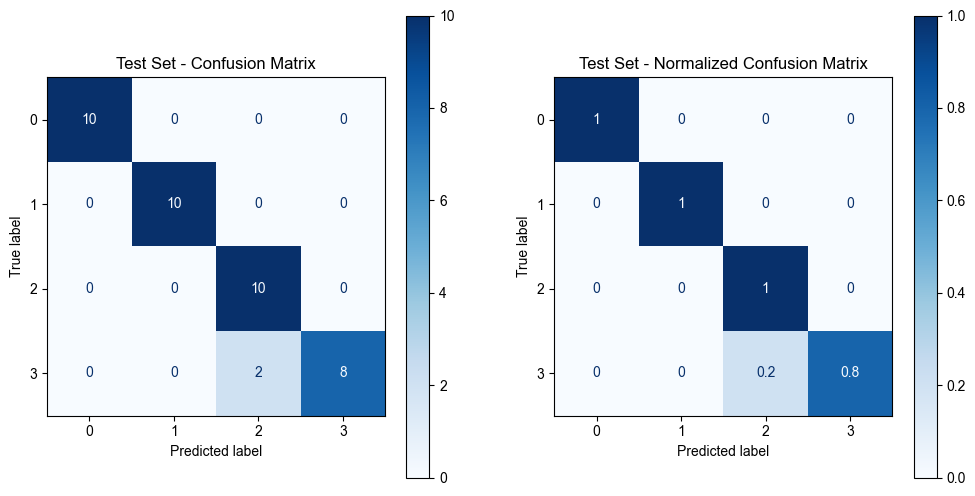

KNeighborsClassifier(n_neighbors=3) Training Set Confusion Matrix:
[[40  0  0  0]
 [ 0 40  0  0]
 [ 0  0 38  2]
 [ 1  0  3 36]]
KNeighborsClassifier(n_neighbors=3) Test Set Confusion Matrix:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  2  8]]
KNeighborsClassifier(n_neighbors=3)
Training set:
Top-1 accuracy: 0.96250
Test set:
Top-1 accuracy: 0.95000



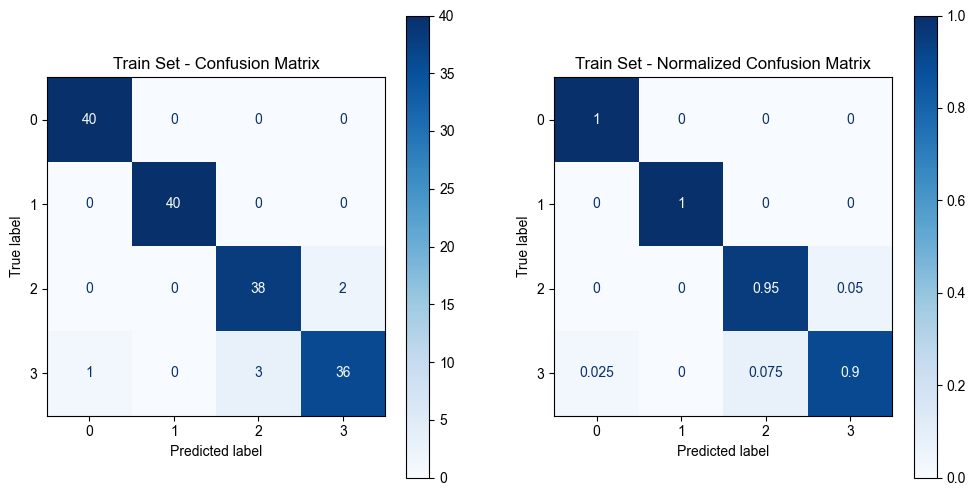

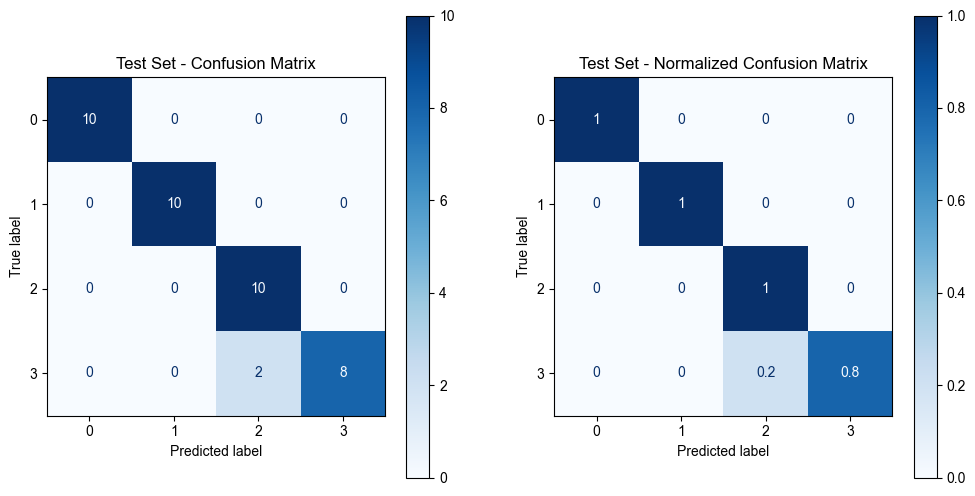

LinearDiscriminantAnalysis() Training Set Confusion Matrix:
[[38  0  2  0]
 [ 3 37  0  0]
 [ 0  0 40  0]
 [ 0  0  6 34]]
LinearDiscriminantAnalysis() Test Set Confusion Matrix:
[[10  0  0  0]
 [ 1  9  0  0]
 [ 0  0 10  0]
 [ 0  0  3  7]]
LinearDiscriminantAnalysis()
Training set:
Top-1 accuracy: 0.93125
Test set:
Top-1 accuracy: 0.90000



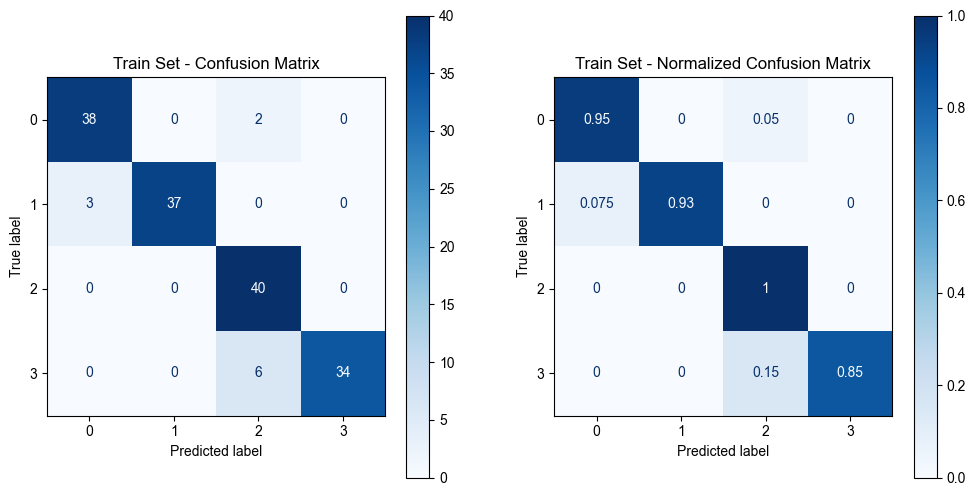

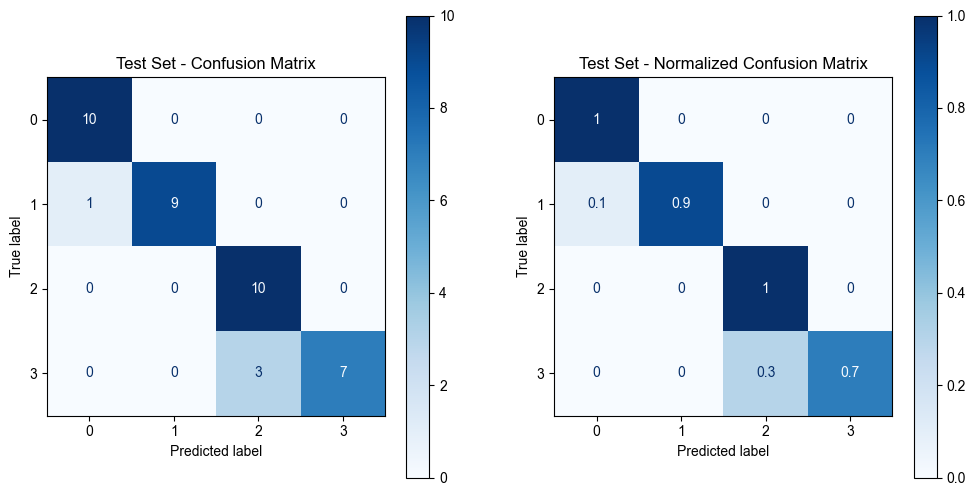

ELMClassifier(n_hidden_nodes=50) Training Set Confusion Matrix:
[[32  2  6  0]
 [ 1 39  0  0]
 [ 4  0 35  1]
 [ 1  1  2 36]]
ELMClassifier(n_hidden_nodes=50) Test Set Confusion Matrix:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 1  0  9  0]
 [ 0  0  2  8]]
ELMClassifier(n_hidden_nodes=50)
Training set:
Top-1 accuracy: 0.88750
Test set:
Top-1 accuracy: 0.92500



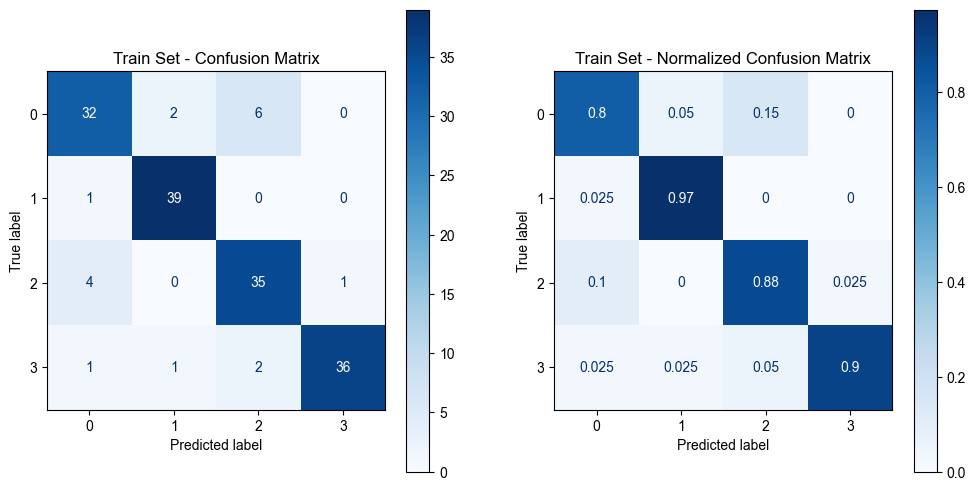

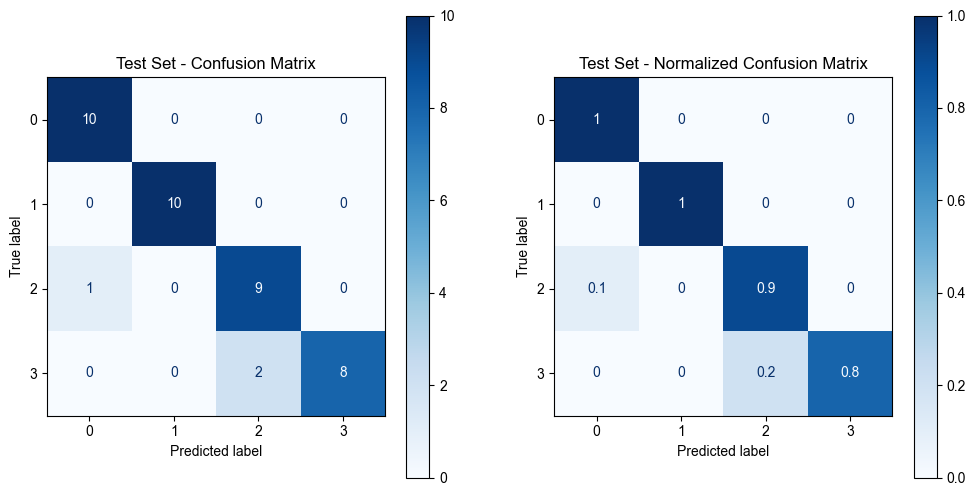

RVFLClassifier(n_hidden_nodes=10) Training Set Confusion Matrix:
[[37  0  2  1]
 [ 2 38  0  0]
 [ 0  0 38  2]
 [ 0  0  6 34]]
RVFLClassifier(n_hidden_nodes=10) Test Set Confusion Matrix:
[[10  0  0  0]
 [ 1  9  0  0]
 [ 0  0 10  0]
 [ 0  0  2  8]]
RVFLClassifier(n_hidden_nodes=10)
Training set:
Top-1 accuracy: 0.91875
Test set:
Top-1 accuracy: 0.92500



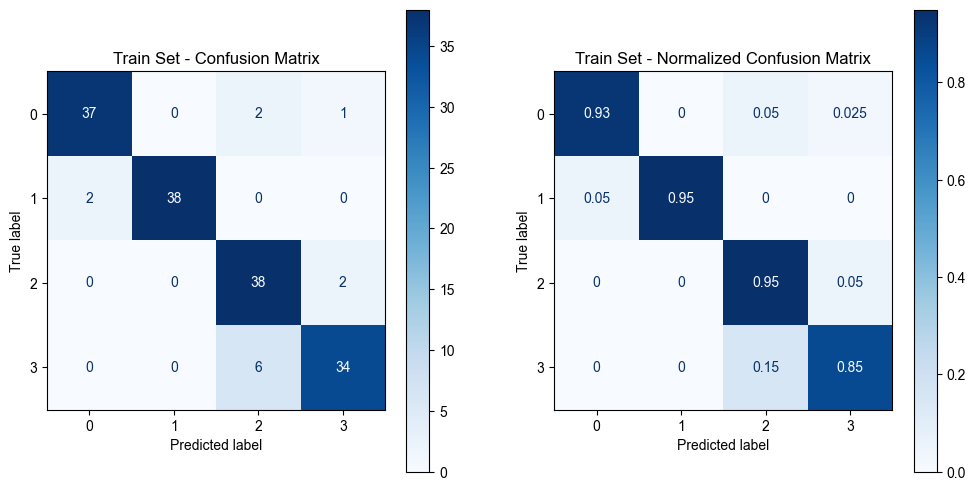

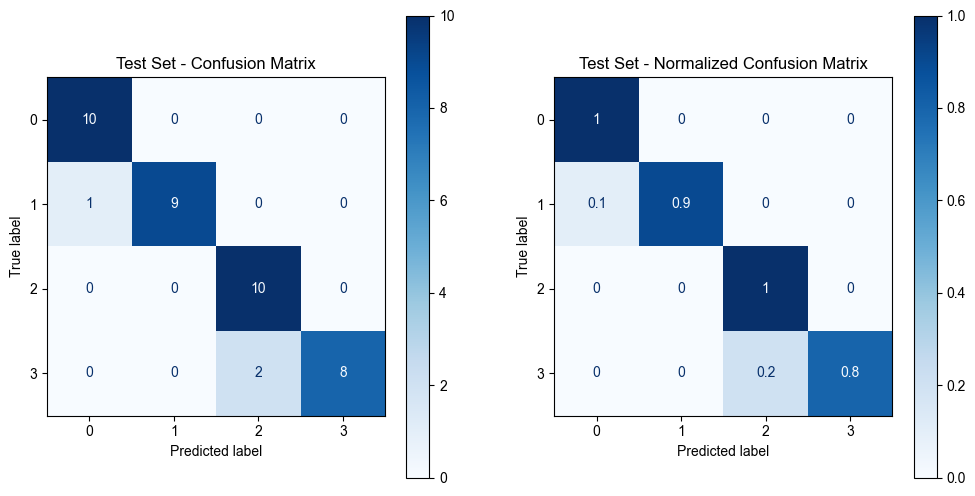

GaussianNB() 训练集总体平均准确率（Accuracy）: 0.90625
GaussianNB() 训练集总体平均精确率（Precision）: 0.92487
GaussianNB() 训练集总体平均召回率（Recall）: 0.90625
GaussianNB() 训练集总体平均F1分数（F1 Score）: 0.90066

GaussianNB() 测试集总体平均准确率（Accuracy）: 0.85000
GaussianNB() 测试集总体平均精确率（Precision）: 0.90625
GaussianNB() 测试集总体平均召回率（Recall）: 0.85000
GaussianNB() 测试集总体平均F1分数（F1 Score）: 0.83516

DecisionTreeClassifier(max_depth=40) 训练集总体平均准确率（Accuracy）: 1.00000
DecisionTreeClassifier(max_depth=40) 训练集总体平均精确率（Precision）: 1.00000
DecisionTreeClassifier(max_depth=40) 训练集总体平均召回率（Recall）: 1.00000
DecisionTreeClassifier(max_depth=40) 训练集总体平均F1分数（F1 Score）: 1.00000

DecisionTreeClassifier(max_depth=40) 测试集总体平均准确率（Accuracy）: 0.97500
DecisionTreeClassifier(max_depth=40) 测试集总体平均精确率（Precision）: 0.97727
DecisionTreeClassifier(max_depth=40) 测试集总体平均召回率（Recall）: 0.97500
DecisionTreeClassifier(max_depth=40) 测试集总体平均F1分数（F1 Score）: 0.97494

RandomForestClassifier(n_estimators=9) 训练集总体平均准确率（Accuracy）: 1.00000
RandomForestClassifier(n_estimators=9) 训练集总体平均精

In [375]:
dic_train_accs, dic_test_accs = run_multiclass_clfs_gridsearch(Xs_train, y_train, Xs_test, y_test)

In [430]:
#卡方特征
feature_indices = [123,122,124,108,86,87,109,125,89]

In [444]:
Xs_train = X_train[:, feature_indices] # 训练集选择的特征
Xs_train.shape

(160, 9)

In [446]:
# 处理测试集
Xs_test = X_test[:, feature_indices]
Xs_test.shape

(40, 9)

In [448]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import top_k_accuracy_score, f1_score
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model_stability(clf, param_grid, X_train, y_train, X_test, y_test, class_labels, n_runs=10):
    """评估模型稳定性并返回统计量"""
    test_accuracies = []
    test_precisions = []
    test_recalls = []
    test_f1_scores = []  # 新增F1-score
    all_test_cms = []
    trained_models = []  # 存储训练好的模型
    
    print(f"正在进行 {clf.__class__.__name__} 的稳定性评估 ({n_runs} 次运行)...")
    
    for run in range(n_runs):
        # 每次运行都重新进行网格搜索
        current_seed = 20 + run  # 使用不同的种子
        kfold = KFold(n_splits=3, shuffle=True, random_state=current_seed)
        
        gs = GridSearchCV(clf, param_grid, cv=kfold, n_jobs=1, verbose=0)
        gs.fit(X_train, y_train)
        
        best_clf = gs.best_estimator_
        trained_models.append(best_clf)  # 保存训练好的模型
        
        # 预测并计算指标
        y_pred_test = best_clf.predict(X_test)
        test_cm = confusion_matrix(y_test, y_pred_test)
        all_test_cms.append(test_cm)
        
        # 计算准确率
        test_acc = best_clf.score(X_test, y_test)
        test_accuracies.append(test_acc)
        
        # 计算精确率、召回率和F1-score（按类别平均）
        precisions = []
        recalls = []
        f1_scores = []
        for i in range(len(test_cm)):
            TP = test_cm[i][i]
            FP = sum(test_cm[j][i] for j in range(len(test_cm))) - TP
            FN = sum(test_cm[i]) - TP
            
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
        
        test_precisions.append(np.mean(precisions))
        test_recalls.append(np.mean(recalls))
        test_f1_scores.append(np.mean(f1_scores))  # 计算平均F1-score
    
    # 计算统计量
    def calculate_confidence_interval(data, confidence=0.95):
        n = len(data)
        if n < 2:
            return np.mean(data), np.mean(data), np.mean(data)
        mean = np.mean(data)
        std_err = stats.sem(data)
        h = std_err * stats.t.ppf((1 + confidence) / 2., n-1)
        return mean, mean-h, mean+h
    
    acc_mean, acc_ci_low, acc_ci_high = calculate_confidence_interval(test_accuracies)
    prec_mean, prec_ci_low, prec_ci_high = calculate_confidence_interval(test_precisions)
    rec_mean, rec_ci_low, rec_ci_high = calculate_confidence_interval(test_recalls)
    f1_mean, f1_ci_low, f1_ci_high = calculate_confidence_interval(test_f1_scores)  # F1-score的置信区间
    
    # 找到最具代表性的混淆矩阵（最接近平均准确率的那次运行）
    representative_idx = np.argmin(np.abs(test_accuracies - acc_mean))
    representative_cm = all_test_cms[representative_idx]
    representative_model = trained_models[representative_idx]  # 对应的训练好的模型
    
    # 误判分析
    misclassification_analysis = []
    n_classes = len(representative_cm)
    for i in range(n_classes):
        for j in range(n_classes):
            if i != j and representative_cm[i][j] > 0:
                misclassification_analysis.append({
                    'true_class': class_labels[i],
                    'predicted_class': class_labels[j],
                    'count': representative_cm[i][j],
                    'percentage': representative_cm[i][j] / np.sum(representative_cm[i]) * 100
                })
    
    # 按误判数量排序
    misclassification_analysis.sort(key=lambda x: x['count'], reverse=True)
    
    stability_results = {
        'accuracy': {
            'mean': acc_mean, 'std': np.std(test_accuracies),
            'ci_low': acc_ci_low, 'ci_high': acc_ci_high,
            'all_values': test_accuracies
        },
        'precision': {
            'mean': prec_mean, 'std': np.std(test_precisions),
            'ci_low': prec_ci_low, 'ci_high': prec_ci_high
        },
        'recall': {
            'mean': rec_mean, 'std': np.std(test_recalls),
            'ci_low': rec_ci_low, 'ci_high': rec_ci_high
        },
        'f1_score': {  # 新增F1-score
            'mean': f1_mean, 'std': np.std(test_f1_scores),
            'ci_low': f1_ci_low, 'ci_high': f1_ci_high
        },
        'representative_cm': representative_cm,
        'representative_model': representative_model,  # 保存训练好的模型
        'misclassification_analysis': misclassification_analysis
    }
    
    return stability_results

def run_multiclass_clfs_gridsearch(Xs_train, y_train, Xs_test, y_test):
    # 定义分类器和参数网格
    clfs = [
        GaussianNB(),
        DecisionTreeClassifier(random_state=20),
        RandomForestClassifier(random_state=20),
        LinearSVC(multi_class="crammer_singer"),
        LogisticRegressionCV(multi_class="multinomial", max_iter=1000, random_state=20),
        MLPClassifier(random_state=20),
        KNeighborsClassifier(),
        LinearDiscriminantAnalysis(),
        # ELMClassifier(),  # 注释掉，如需使用请取消注释
        # RVFLClassifier()   # 注释掉，如需使用请取消注释
    ]

    param_grids = [
        {},
        {'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40]},
        {'n_estimators': list(range(1, max(10, len(set(y_train)))))},
        {'C': [0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 1000]},
        {},
        {'hidden_layer_sizes': [(x,) for x in range(1, 1000, 10)], 'alpha': [0.0001, 0.01, 1]},
        {'n_neighbors': list(range(1, max(5, len(set(y_train)))))},
        {},
        # {'n_hidden_nodes': [1, 2, 5, 10, 20, 25, 30, 35, 40, 50, 60, 75, 100, 150, 200]},
        # {'n_hidden_nodes': [1, 2, 5, 10, 20, 40, 50, 60, 70, 80, 90, 100]}
    ]

    # 初始化存储结果
    confusion_matrix_results = []
    dic_train_accs = {}
    dic_test_accs = {}
    stability_results_dict = {}
    trained_models_dict = {}  # 存储训练好的模型

    kfold = KFold(n_splits=3, shuffle=True, random_state=20)

    for i, (clf, param_grid) in enumerate(zip(clfs, param_grids)):
        clf_name = clf.__class__.__name__
        print(f"\n{'='*60}")
        print(f"训练分类器: {clf_name}")
        print(f"{'='*60}")

        # 对于RF和MLP，使用稳定性评估
        if clf_name in ['RandomForestClassifier', 'MLPClassifier']:
            stability_results = evaluate_model_stability(
                clf, param_grid, Xs_train, y_train, Xs_test, y_test, 
                class_labels=np.unique(y_train), n_runs=10
            )
            
            stability_results_dict[clf_name] = stability_results
            trained_models_dict[clf_name] = stability_results['representative_model']  # 保存训练好的模型
            
            # 打印稳定性结果 - 现在包括F1-score
            print(f"\n=== {clf_name} 稳定性评估结果 ===")
            print(f"测试集准确率: {stability_results['accuracy']['mean']:.3f} ± {stability_results['accuracy']['std']:.3f}")
            print(f"95% 置信区间: [{stability_results['accuracy']['ci_low']:.3f}, {stability_results['accuracy']['ci_high']:.3f}]")
            print(f"精确率: {stability_results['precision']['mean']:.3f} ± {stability_results['precision']['std']:.3f}")
            print(f"召回率: {stability_results['recall']['mean']:.3f} ± {stability_results['recall']['std']:.3f}")
            print(f"F1-score: {stability_results['f1_score']['mean']:.3f} ± {stability_results['f1_score']['std']:.3f}")  # 新增F1-score输出
            
            # 打印误判分析
            if stability_results['misclassification_analysis']:
                print(f"\n主要误判模式:")
                for misclass in stability_results['misclassification_analysis'][:3]:
                    print(f"  {misclass['true_class']} → {misclass['predicted_class']}: "
                          f"{misclass['count']} 次 ({misclass['percentage']:.1f}%)")
            else:
                print("无误判情况")
            
            # 使用代表性模型和混淆矩阵
            representative_model = stability_results['representative_model']
            test_cm = stability_results['representative_cm']
            train_cm = confusion_matrix(y_train, representative_model.predict(Xs_train))
            
            # 存储结果
            dic_train_accs[clf_name] = [representative_model.score(Xs_train, y_train)]
            dic_test_accs[clf_name] = [stability_results['accuracy']['mean']]
            
        else:
            # 对于其他分类器，保持原有逻辑
            np.random.seed(20)
            gs = GridSearchCV(clf, param_grid, cv=kfold, n_jobs=1, verbose=0)
            gs.fit(Xs_train, y_train)

            best_clf = gs.best_estimator_
            trained_models_dict[clf_name] = best_clf  # 保存训练好的模型
            
            clf_name_str = str(best_clf)
            
            dic_train_accs[clf_name_str] = [best_clf.score(Xs_train, y_train)]
            dic_test_accs[clf_name_str] = [best_clf.score(Xs_test, y_test)]
            
            y_pred_train = best_clf.predict(Xs_train)
            train_cm = confusion_matrix(y_train, y_pred_train)
            y_pred_test = best_clf.predict(Xs_test)
            test_cm = confusion_matrix(y_test, y_pred_test)
            
            # 更新变量名以保持一致性
            clf_name = clf_name_str
            representative_model = best_clf

        # 创建混淆矩阵结果字典
        confusion_matrix_dict = {
            'classifier_name': clf_name,
            'train_cm': train_cm,
            'test_cm': test_cm,
            'stability_results': stability_results_dict.get(clf_name.split('(')[0], None),
            'trained_model': representative_model
        }
        confusion_matrix_results.append(confusion_matrix_dict)

        # 绘制混淆矩阵
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        # 训练集混淆矩阵
        train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=np.unique(y_train))
        train_disp.plot(ax=ax[0], cmap='Blues')
        ax[0].set_title(f'{clf_name} - Train Set\nConfusion Matrix')

        # 测试集混淆矩阵
        test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=np.unique(y_train))
        test_disp.plot(ax=ax[1], cmap='Blues')
        ax[1].set_title(f'{clf_name} - Test Set\nConfusion Matrix')
        
        plt.tight_layout()
        plt.show()

        # 计算并打印详细指标
        print(f"\n{clf_name} 详细性能指标:")
        print("训练集准确率:", format(dic_train_accs[clf_name][0], '.5f'))
        print("测试集准确率:", format(dic_test_accs[clf_name][0], '.5f'))
        
        # 如果有稳定性结果，显示更多信息
        if clf_name in stability_results_dict:
            print("测试集准确率 (10次运行平均):", format(stability_results_dict[clf_name]['accuracy']['mean'], '.5f'))
            print("标准差:", format(stability_results_dict[clf_name]['accuracy']['std'], '.5f'))
            print("F1-score (10次运行平均):", format(stability_results_dict[clf_name]['f1_score']['mean'], '.5f'))

    return dic_train_accs, dic_test_accs, confusion_matrix_results, stability_results_dict, trained_models_dict

# 使用示例
if __name__ == "__main__":
    # 这里需要您提供实际的数据
    # Xs_train, y_train, Xs_test, y_test = 您的数据
    # dic_train_accs, dic_test_accs, cm_results, stability_results, trained_models = run_multiclass_clfs_gridsearch(Xs_train, y_train, Xs_test, y_test)
    pass


训练分类器: GaussianNB


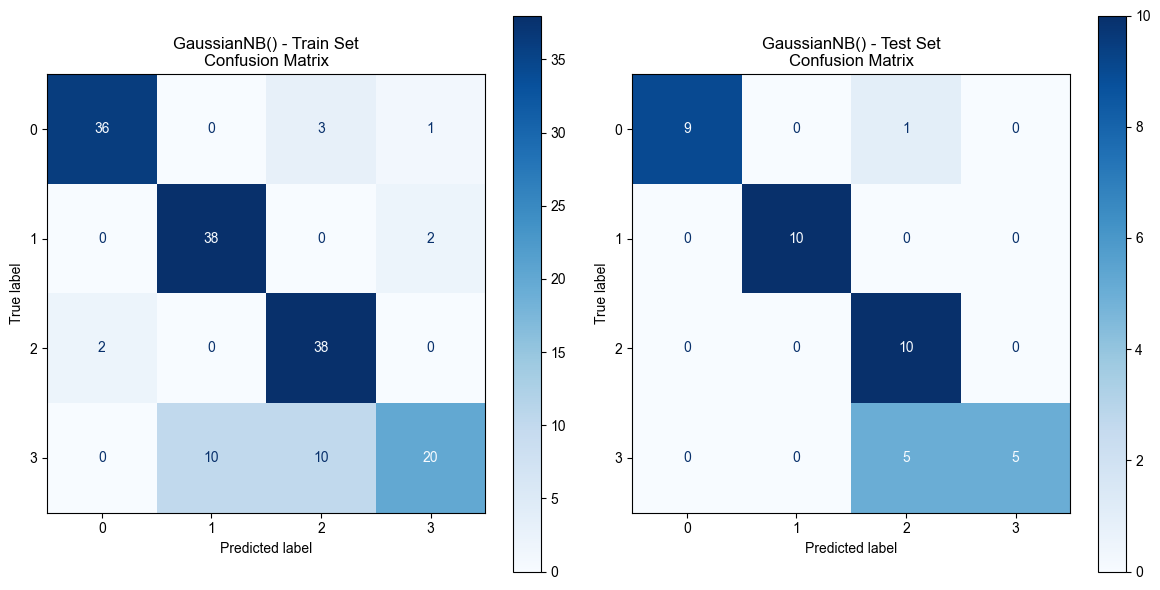


GaussianNB() 详细性能指标:
训练集准确率: 0.82500
测试集准确率: 0.85000

训练分类器: DecisionTreeClassifier


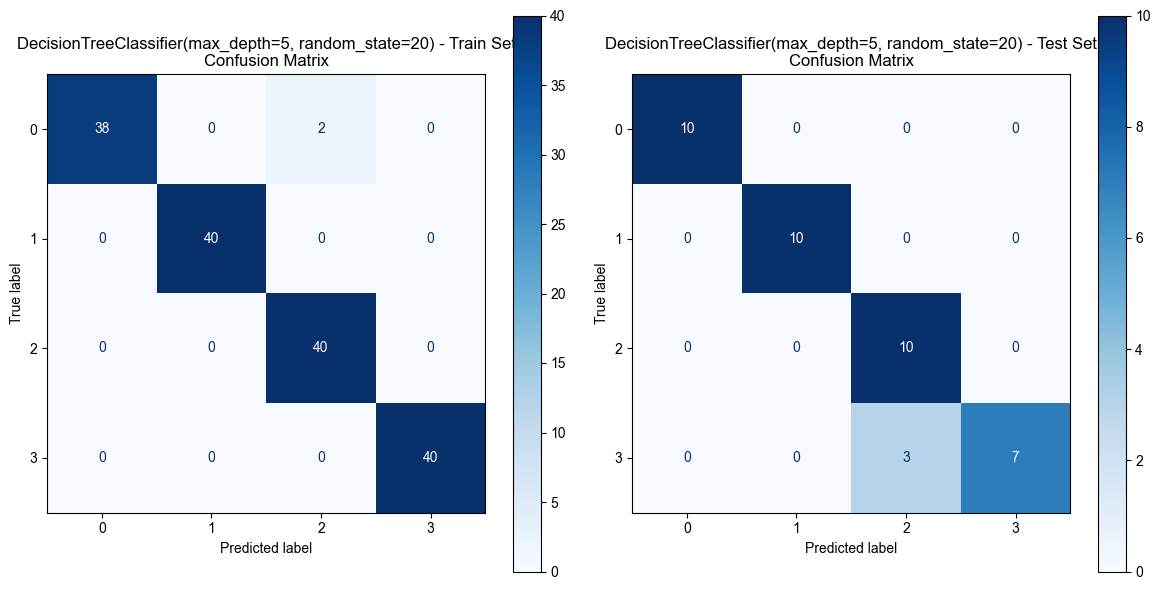


DecisionTreeClassifier(max_depth=5, random_state=20) 详细性能指标:
训练集准确率: 0.98750
测试集准确率: 0.92500

训练分类器: RandomForestClassifier
正在进行 RandomForestClassifier 的稳定性评估 (10 次运行)...

=== RandomForestClassifier 稳定性评估结果 ===
测试集准确率: 0.962 ± 0.013
95% 置信区间: [0.953, 0.972]
精确率: 0.968 ± 0.009
召回率: 0.962 ± 0.013
F1-score: 0.962 ± 0.013

主要误判模式:
  3 → 2: 2 次 (20.0%)


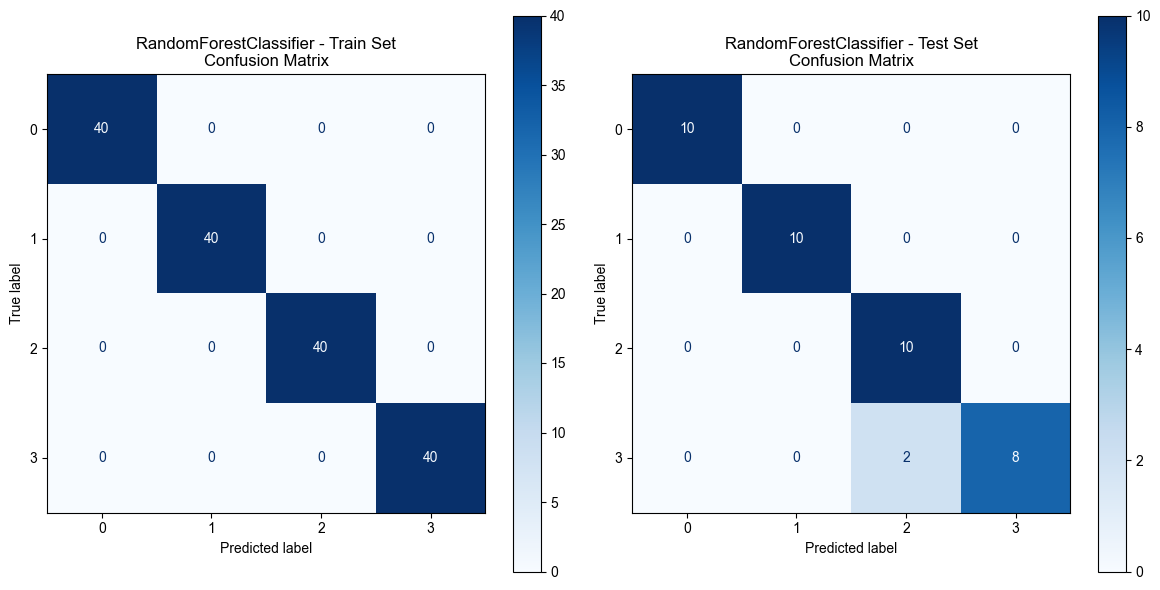


RandomForestClassifier 详细性能指标:
训练集准确率: 1.00000
测试集准确率: 0.96250
测试集准确率 (10次运行平均): 0.96250
标准差: 0.01250
F1-score (10次运行平均): 0.96222

训练分类器: LinearSVC


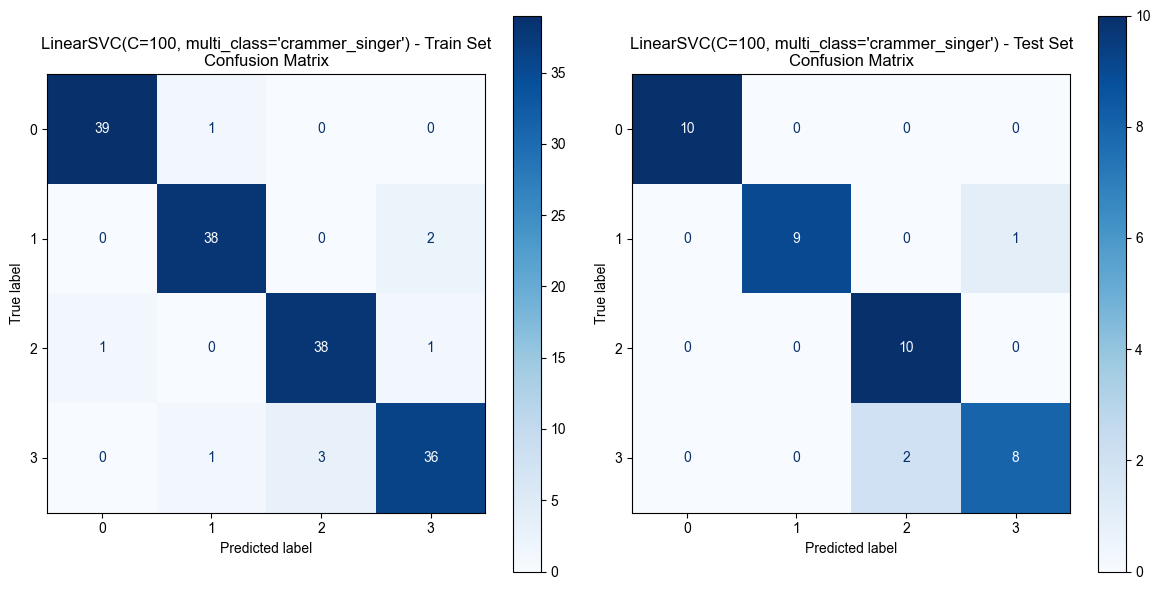


LinearSVC(C=100, multi_class='crammer_singer') 详细性能指标:
训练集准确率: 0.94375
测试集准确率: 0.92500

训练分类器: LogisticRegressionCV


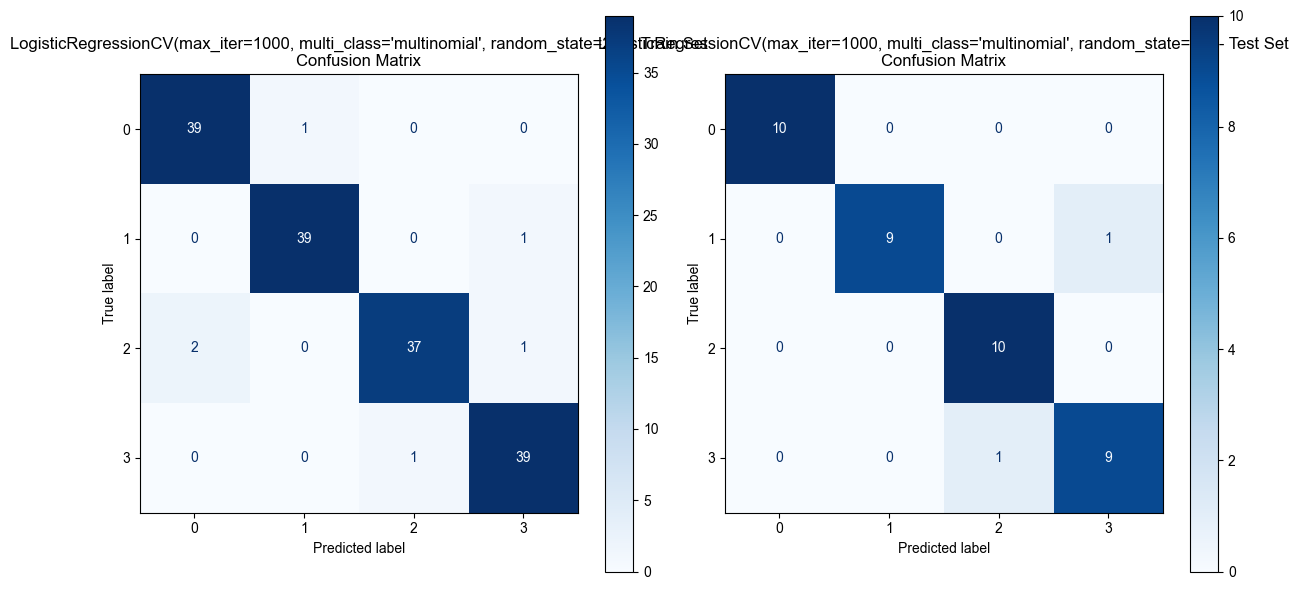


LogisticRegressionCV(max_iter=1000, multi_class='multinomial', random_state=20) 详细性能指标:
训练集准确率: 0.96250
测试集准确率: 0.95000

训练分类器: MLPClassifier
正在进行 MLPClassifier 的稳定性评估 (10 次运行)...


In [ ]:
dic_train_accs, dic_test_accs, confusion_matrix_results, stability_results_dict, trained_models_dict = run_multiclass_clfs_gridsearch(Xs_train, y_train, Xs_test, y_test)